# Part 1 Sequence Tagging: NER


## Q1.1 Word Embedding

### Q1.1.1 Download Dependency

In [1]:
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


### Q1.1.2 Download the pretrained word2vec embeddings 

In [2]:
import gensim.downloader
import numpy as np
import pandas as pd
import csv
import random
import tqdm
import time
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from seqeval.metrics import f1_score

#Download the embeddings "word2vec-google-news-300"
w2v = gensim.downloader.load('word2vec-google-news-300')

---
### Question 1.1
###### Based on word2vec embeddings you have downloaded, use cosine similarity to find the most similar word to each of these words: (a) “student”; (b) “Apple”; (c) “apple”. Report the most similar word and its cosine similarity.

In [3]:
def get_word_and_cosine_similarity(word:list, top_n:int):
    result = {}
    for w in word:
        similarities = w2v.cosine_similarities(w2v[w], w2v.vectors)
        sorted_similarities = sorted(similarities[:], reverse=True)[:top_n+1]
        result[w] = [(w2v.index_to_key[np.where(similarities == s)[0][0]], s) for s in sorted_similarities if w2v.index_to_key[np.where(similarities == s)[0][0]]!=w]
    return result

In [4]:
word_list = ["student", "Apple", "apple"]
print("Most similar word and its cosine similarity by using .most_similar(): ")
for word in word_list:
    print(word+'\t', w2v.most_similar(word,topn=1))

print("\nMost similar word and its cosine similarity by using .cosine_similarities(): ")
r = get_word_and_cosine_similarity(word_list, 1)
for k,v in r.items():
    print(k+'\t', v)

Most similar word and its cosine similarity by using .most_similar(): 
student	 [('students', 0.7294867038726807)]
Apple	 [('Apple_AAPL', 0.7456986308097839)]
apple	 [('apples', 0.720359742641449)]

Most similar word and its cosine similarity by using .cosine_similarities(): 
student	 [('students', 0.7294867)]
Apple	 [('Apple_AAPL', 0.74569863)]
apple	 [('apples', 0.72035974)]


---
### 1.2 Data
###### Then you can start to prepare the dataset. For NER, you will work with [CoNLL2003](https://github.com/TheAnig/NER-LSTM-CNN-Pytorch/tree/master/data) (click and download “eng.testa”, “eng.testb”, “eng.train”). Before training, you need to preprocess the dataset such that each of them contains a training file, a development file and a test file. The development file is used to select the best model during training. The test file is used for final evaluation. For CoNLL2003, the training, development and test file corresponds to “eng.train”, “eng.testa” and “eng.testb”, respectively. Note that you only need to use the first and the last column of each line corresponding to the input word and the word label, respectively. A screenshot of the data is shown in Figure 1. In this example, there are two sentences (separated by ‘\n’). The input for each sentence is composed of the words from the first column. For example, the first sentence in Figure 1 corresponds to “CRICKET - LEICESTERSHIRE TAKE OVER AT TOP AFTER INNINGS VICTORY.” The label for each of the first 3 words CRICKET, -, LERCESTERSHIRE corresponds to ‘O’, ‘O’, ‘I-ORG’, respectively

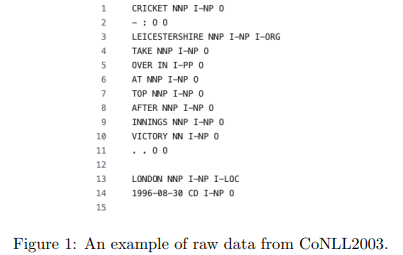

In [5]:
# Define the file paths
train_file = "data/Part 1/eng.train"
verification_file = "data/Part 1/eng.testa"
test_file = "data/Part 1/eng.testb"

# Function to read and process a CoNLL2003 file and returns df
def process_files(file_path, csv_name):
    """ Parameters:
        - file_path: CoNLL2003 files
        - csv_name: Bool
             returns pd file, columns: ["Sentence Number", "Word", "NEr tag"]
    """
    data = []
    sentence_no = 1
    with open(file_path, 'r', encoding='utf-8') as file:
        for row in file:
            line = row.strip()
            if not line:  # Empty line indicates end of a sentence
                sentence_no += 1
            else:
                ner = line.split(" ")
                # ensuring that for each data there is a word and the word's NER label
                assert all([ner[i] for i in range(4)])
                data.append([sentence_no, ner[0], ner[3]])

    with open(csv_name, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Sentence Number", "Word", "NEr tag"])
        for word in data:
            writer.writerow([word[0], word[1], word[2]])
    return pd.read_csv(csv_name)

# Function to load existing csv file if have
def load_files(file_name):
    return pd.read_csv(file_name)

# Process the data files
train_df = process_files(train_file, csv_name="data/Part 1/train_data.csv")
validation_df = process_files(verification_file, csv_name="data/Part 1/verification_data.csv")
test_df = process_files(test_file, csv_name="data/Part 1/test_data.csv")

### Question 1.2
###### (a) Describe the size (number of sentences) of the training, development and test file for CoNLL2003. Specify the complete set of all possible word labels based on the tagging scheme (IO, BIO, etc.) you chose.

In [6]:
file_labels = ["Training", "Verification", "Test"]
for i, df in enumerate([train_df, validation_df, test_df]):
    print("="*100)
    print(f"{file_labels[i]} data information")
    print(f"> Number of sentences:    {df['Sentence Number'].max()}")
    print(f"> Count of Unique words:  {len(df['Word'].unique())}")
    print(f"> Type of tags:           {sorted(df['NEr tag'].unique())}\n")
print("="*100,'\n')

print("With the given shapes, parameters and type of tags exists, we select the tagging scheme to be BIO as it has B,I,O tags.")

Training data information
> Number of sentences:    14987
> Count of Unique words:  23623
> Type of tags:           ['B-LOC', 'B-MISC', 'B-ORG', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

Verification data information
> Number of sentences:    3466
> Count of Unique words:  9966
> Type of tags:           ['B-MISC', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

Test data information
> Number of sentences:    3684
> Count of Unique words:  9489
> Type of tags:           ['B-LOC', 'B-MISC', 'B-ORG', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']


With the given shapes, parameters and type of tags exists, we select the tagging scheme to be BIO as it has B,I,O tags.


###### (b) Choose an example sentence from the training set of CoNLL2003 that has at least two named entities with more than one word. Explain how to form complete named entities from the label for each word, and list all the named entities in this sentence.

In [7]:
def q1b(df):
    while True:
        # Keeps track of number of entities
        count =0
        
        # Generate a random sentence number
        rand = random.randint(1,df['Sentence Number'].iloc[-1]+1)

        # Filter df by sentence_number
        mask = df['Sentence Number'] == rand
        rand_df = df[mask].reset_index()

        # Check is to ensure we do not double count consecutive word with same tag
        check = None

        # Check through dataframe and count number of entities
        for x in range(len(rand_df['NEr tag'])):
            if x < len(rand_df['NEr tag'])-1:
                
                # Check current tag !='O'
                if rand_df['NEr tag'].iloc[x]!='O':
                    
                    # Check if current tag starts with 'B-'
                    if rand_df['NEr tag'].iloc[x].startswith('B-'):
                        
                        # Strip current tag of 'B-' and next tag of 'I-'
                        if rand_df['NEr tag'].iloc[x].strip('B-') == rand_df['NEr tag'].iloc[x+1].strip('I-'):
                            
                             # updating check if tags are the same 
                            if check == rand_df['NEr tag'].iloc[x-1]:
                                check = rand_df['NEr tag'].iloc[x]

                            # Incrementing count and updating check
                            else:
                                count+=1
                                check = rand_df['NEr tag'].iloc[x]
                
                
                    #Check if current tag == next tag
                    elif rand_df['NEr tag'].iloc[x+1] == rand_df['NEr tag'].iloc[x]:

                        # updating check if tags are the same 
                        if check == rand_df['NEr tag'].iloc[x-1]:
                            check = rand_df['NEr tag'].iloc[x]

                        # Incrementing count and updating check
                        else:
                            count+=1
                            check = rand_df['NEr tag'].iloc[x]

                # Reinitialise check to None once 'O' detected to ensure other different named entities of same tag as previous is counted.
                elif rand_df['NEr tag'].iloc[x]=='O':
                    check = None

                # Return once count >=2
                if count >=2:
                    return rand_df          

def process(df):
    sentence = ''
    tag = ''
    sen_and_tag = ''
    for x in range (len(df['Word'])):
        sentence += str(df['Word'].iloc[x])
        sentence+= ' '
        tag += str(df['NEr tag'].iloc[x])
        tag+=' '
        sen_and_tag +=str(df['Word'].iloc[x])
        sen_and_tag +='/'
        sen_and_tag += str(df['Word'].iloc[x])
        sen_and_tag += ' '
    print(f"sentence: {sentence}")
    print(f"tag: {tag}")
    print(f"sentence with tag: {sen_and_tag}")   

q1b_df = q1b(train_df)      
process(q1b_df)

sentence: 71 Steven Bottomley , Ove Sellberg ( Sweden ) , Joakim Haeggman 
tag: O I-PER I-PER O I-PER I-PER O I-LOC O O I-PER I-PER 
sentence with tag: 71/71 Steven/Steven Bottomley/Bottomley ,/, Ove/Ove Sellberg/Sellberg (/( Sweden/Sweden )/) ,/, Joakim/Joakim Haeggman/Haeggman 


In [8]:
def check(df):
    # Keeps track of number of entities
    count =0
    
    # Check is to ensure we do not double count consecutive word with same tag
    check = None

    # Check through dataframe and count number of entities
    for x in range(len(df['NEr tag'])):
        if x < len(df['NEr tag'])-1:
            # Check tag !='O', next tag is same as current tag 
            if df['NEr tag'].iloc[x]!='O':
                if df['NEr tag'].iloc[x].startswith('B-'):
                    if df['NEr tag'].iloc[x].strip('B-') == df['NEr tag'].iloc[x+1].strip('I-'):
                            # updating check if tags are the same 
                        if check == df['NEr tag'].iloc[x-1]:
                            check = df['NEr tag'].iloc[x]

                        # Incrementing count and updating check
                        else:
                            count+=1
                            check = df['NEr tag'].iloc[x]
            
            
            
                elif df['NEr tag'].iloc[x+1] == df['NEr tag'].iloc[x]:

                    # updating check if tags are the same 
                    if check == df['NEr tag'].iloc[x-1]:
                        check = df['NEr tag'].iloc[x]

                    # Incrementing count and updating check
                    else:
                        count+=1
                        check = df['NEr tag'].iloc[x]

            # Reinitialise check to None once 'O' detected to ensure other different named entities of same tag as previous is counted.
            elif df['NEr tag'].iloc[x]=='O':
                check = None
           
    return count
mask = train_df['Sentence Number'] == 679
df = train_df[mask].reset_index()
print(check(df))
process(df)

2
sentence: Australian Davis Cup captain John Newcombe on Thursday signalled his possible resignation if his team loses an away tie against Croatia next month . 
tag: I-MISC B-MISC I-MISC O I-PER I-PER O O O O O O O O O O O O O O I-LOC O O O 
sentence with tag: Australian/Australian Davis/Davis Cup/Cup captain/captain John/John Newcombe/Newcombe on/on Thursday/Thursday signalled/signalled his/his possible/possible resignation/resignation if/if his/his team/team loses/loses an/an away/away tie/tie against/against Croatia/Croatia next/next month/month ./. 


In [9]:
def list_named_entities(df):
    entity =''
    l =[]
    t = []
    for x in range(len(df['Word'])):
        if df['NEr tag'].iloc[x]!='O':
            entity+=str(df['Word'].iloc[x])
            entity+=' '
        else:
            if (entity!=''):
                l.append(entity)
                t.append(str(df['NEr tag'].iloc[x-1]))
                entity = ''
    d = {k: v for k, v in zip(l,t)} 
    return l,d

l,d= list_named_entities(q1b_df)
print(f"list of name entities: {l}")
print(f"list of name entities with tags {d}")

print('\nTo form complete named entities from the label for each word, we need to consider firstly that the tags are provided/able to be retrieved by corpus/gazetteer. For each single/consequtive Name Entities(ER) recognition tags, it is the complete phrase of the name entity. The type of the entity can be known by the tag itself, if in this example, ORG was tagged and hence we know the word/phrase is an Organization. However, the data provided does not fully follow the BIO tagging scheme entirely, with the start of the NE phrase not tagged with a "B", and since when we are using the "BIO" tagging scheme there is no Stop/Ending tags, hence the only way we can segregate phrases is by using the "O"-outside "BIO" tag. ')

list of name entities: ['Steven Bottomley ', 'Ove Sellberg ', 'Sweden ']
list of name entities with tags {'Steven Bottomley ': 'I-PER', 'Ove Sellberg ': 'I-PER', 'Sweden ': 'I-LOC'}

To form complete named entities from the label for each word, we need to consider firstly that the tags are provided/able to be retrieved by corpus/gazetteer. For each single/consequtive Name Entities(ER) recognition tags, it is the complete phrase of the name entity. The type of the entity can be known by the tag itself, if in this example, ORG was tagged and hence we know the word/phrase is an Organization. However, the data provided does not fully follow the BIO tagging scheme entirely, with the start of the NE phrase not tagged with a "B", and since when we are using the "BIO" tagging scheme there is no Stop/Ending tags, hence the only way we can segregate phrases is by using the "O"-outside "BIO" tag. 


---
## 1.3 Model
###### Now with the pretrained word embeddings acquired from Section 1.1, and the CoNLL2003 dataset acquired from Section 1.2, you need to train an NER model using the training set, conforming to these requirements:
• Use the pretrained word embeddings from Section 1.1 as inputs; do not update them during training (they are “frozen”).

• Design a neural network transforming the input for each word to its final vector representation, which will be fed into the softmax classifier to predict the final label for each word. The neural network could be a simple linear layer, a feedforward network (a linear transformation plus a nonlinear activation function), or a recurrent neural network (RNN/LSTM). You are encouraged to use more effective networks (e.g., LSTM) because the performance of the model will be taken into consideration when graded.

• Use the development set to evaluate the performance of the model for each epoch during training. Please use f1 score to measure the performance. For evaluation metric and code, refer to the following link: https://github.com/chakki-works/seqeval/tree/master. (Please make sure your sequence tagging scheme aligns with the provided evaluation code. Otherwise,
you may revise the code accordingly.)

• Use the mini-batch strategy during training. You may choose any preferred optimizer (e.g., SGD, Adagrad, Adam, RMSprop). Be careful when you choose your initial learning rate and mini-batch size. (You may use the development set to check the performance and decide the optimal configuration.) Train the network until the f1 score on the development set is not increasing. Use the trained network to classify words in the test set.

---
### Data exploration and getting sequence data

Max sentences for train_df=113,
      validation_df=109, test_df=124


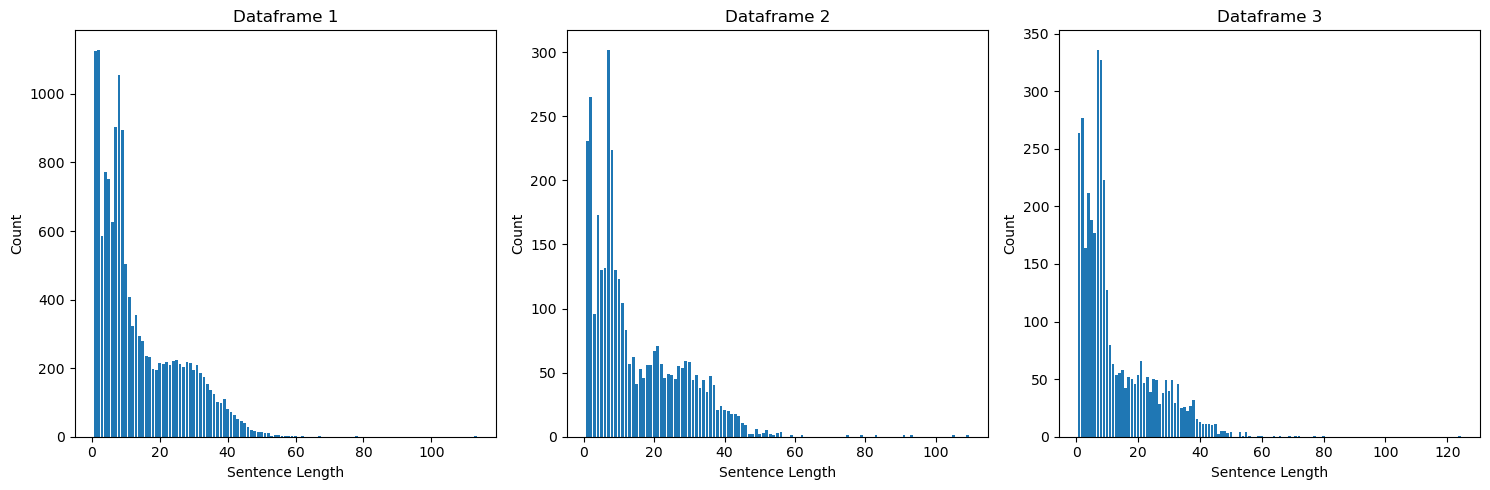

In [10]:
from collections import defaultdict
import matplotlib.pyplot as plt

def sentence_integrate(data):
    agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                 s["NEr tag"].values.tolist())]
    return data.groupby('Sentence Number').apply(agg_func).tolist()
  
train_df_sentences = sentence_integrate(train_df)
validation_df_sentences = sentence_integrate(validation_df)
test_df_sentences = sentence_integrate(test_df)

count_of_sentence_lengths = [defaultdict(int) for _ in range(3)]
for idx, data in enumerate([train_df_sentences, validation_df_sentences, test_df_sentences]):
    for s in data:
        count_of_sentence_lengths[idx][len(s)] += 1

# Create subplots for each dataframe
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms for each dataframe
for idx, count_dict in enumerate(count_of_sentence_lengths):
    lengths = list(count_dict.keys())
    counts = list(count_dict.values())
    
    axes[idx].bar(lengths, counts)
    axes[idx].set_title(f'Dataframe {idx + 1}')
    axes[idx].set_xlabel('Sentence Length')
    axes[idx].set_ylabel('Count')

print(f"""Max sentences for train_df={max(count_of_sentence_lengths[0])},
      validation_df={max(count_of_sentence_lengths[1])}, test_df={max(count_of_sentence_lengths[2])}""")
plt.tight_layout()
plt.show()

### Initialize Single LSTM model class and model helper functions

In [34]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

# Set a specific random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)

class NERDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class NERModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_labels, pretrained_embeddings, dropout_prob=0.2):
        super(NERModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)  # Freeze the embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, num_labels)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x, random_initial_state=False):    
        embedded_x = self.embedding(x)
        
        if random_initial_state:
            h0 = torch.randn(1, embedded_x.size(0), self.hidden_dim).to(device)
            c0 = torch.randn(1, embedded_x.size(0), self.hidden_dim).to(device)
            lstm_out, _ = self.lstm(embedded_x, (h0, c0))
        else:
            lstm_out, _ = self.lstm(embedded_x)
            
        logits = self.linear(lstm_out)
        drop_out = self.dropout(logits)
        output = self.softmax(drop_out)
        return output

def get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings):
    return NERModel(embedding_dim, hidden_dim, num_labels, pretrained_embeddings)
    
def save_model(model, name_="NERModel.pth"):
    torch.save(model.state_dict(), name_)
    return True

def load_model(model, name_="NERModel.pth"):
    loaded_model.load_state_dict(torch.load('model.pth'))
    return True

### Initialize data helper class functions

In [28]:
def preprocess_data(df, w2v_model, ner_label_mapping, max_sequence_length):
    ''' Convert df data to useful data to be trained and test on.
    Returns:
        sequences: tensor([][int]), stores word_to_idx sequence data.
        labels: tensor([][int]), stores index mapping of NER tagging.
        actual_sentence_len: LongTensor([int]), stores the actual sequence length, before paddings.
    '''
    sequences, labels, actual_sentence_len  = [], [], []
    
    # Process each sentence
    for sentence_number, sentence_data in df.groupby('Sentence Number'):
        # Tokenize the sentence
        sentence_tokens = sentence_data['Word'].values.tolist()
        ner_tags = sentence_data['NEr tag'].values.tolist()
        
        # Store the actual length of the sentence
        actual_sentence_len.append(len(sentence_tokens))
        
        # Create numerical labels for NER tags
        numerical_labels = [ner_label_mapping.get(tag, ner_label_mapping['O']) for tag in ner_tags]

        # Pad for every sequence less than the max_sequence_length
        if len(sentence_tokens) < max_sequence_length:
            num_tokens = len(sentence_tokens)
            num_padding = max_sequence_length - num_tokens
            sentence_tokens += ["<PADDED>"] * num_padding
            numerical_labels += [ner_label_mapping['O']] * num_padding
        assert len(sentence_tokens) == len(numerical_labels) == max_sequence_length
        if '</s>' in sentence_tokens: print(sentence_tokens)
        word_vectors = [w2v.index_to_key.index(token) if token in w2v_model else 3000000 for token in sentence_tokens]    
        sequences.append(word_vectors)
        labels.append(numerical_labels)
    return  torch.tensor(sequences), torch.tensor(labels, dtype=torch.long), torch.LongTensor(actual_sentence_len)

from torch.utils.data import DataLoader, TensorDataset
def get_training_data(batch_size, ner_label_mapping):
    ''' packs datas with data_loader.
    Returns train and validation data loaders, as well as their data actual lengths
    '''
    X_train, y_train, train_sentence_len = preprocess_data(train_df, w2v, ner_label_mapping, train_max_len)
    train_dataset = NERDataset(X_train, y_train)
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(random_seed))

    X_validation, y_validation, validation_sentence_len = preprocess_data(validation_df, w2v, ner_label_mapping, val_max_len)
    validation_dataset = NERDataset(X_validation, y_validation)
    validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(random_seed))
    
    return train_data_loader, validation_data_loader, train_sentence_len, validation_sentence_len

def get_test_data(batch_size, ner_label_mapping):
    ''' packs datas with data_loader.
    Returns test data loaders, as well as their data actual lengths. 
    It is integrated seperately for easier maintainability and readability.
    '''
    X_test, y_test, test_sentence_len = preprocess_data(test_df, w2v, ner_label_mapping, test_max_len)
    test_dataset = NERDataset(X_test, y_test)
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(random_seed))
    
    return test_data_loader, test_sentence_len

# Using Early stopper to stop when the F1Score prediction drops 
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_f1_score_ = 0

    def early_stop(self, f1_score_):
        if f1_score_ > self.min_f1_score_:
            self.min_f1_score_ = f1_score_
            self.counter = 0
        elif f1_score_ < (self.min_f1_score_ + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def plot_findings(X_axis:list, Y_axis:list, X_label:str, Y_labels:list = ["F1 Score", "Accuracy", "Time Taken (Seconds)"], isoptimal=False):
    ''' highly specific customized utility function for plotting results obtained, toggle state[isoptimal] between findings/optimal result.
    Parameters:
        X_axis: put length of "Batch_size" / "Epoch" here
        Y_axis: measurement parameters: [f1_score, accuracy, time] / 
                [[train_accuracies, val_accuracies], [train_losses, val_losses], [f1_score_arr]]
        X_label: put label of "Batch Size" / "Epoch" here
        Y_label: Optional, default: [f1_score, accuracy, time]
        isoptimal: Bool 
    '''
    # Create a line chart for accuracy with the exact X values
    plt.figure(figsize=(10, 4))
    color = ['r','g','b']
    optimal_labels = [["Train_accuracy","Validation_accuracy"], ["Train_losses", "Validation_losses"], ["F1_score"]]

    for i in range(3):
        plt.subplot(1, 3, i+1)
        if not isoptimal:
            plt.plot(range(len(X_axis)), Y_axis[i], marker='o', linestyle='-', color=color[i], label=Y_labels[i])
            plt.xticks(range(len(X_axis)), X_axis)
        else:
            plt.plot(range(1, X_axis+1), Y_axis[i][0], color='r', label=optimal_labels[i][0])
            if i != 2: plt.plot(range(1, X_axis+1), Y_axis[i][1], color='g', label=optimal_labels[i][1])
            Y_labels = ["accuracy", "losses", "F1 score"]
        plt.xlabel(X_label)
        plt.ylabel(Y_labels[i])
        plt.title(f'{Y_labels[i]} vs. {X_label}')
        plt.grid(True)
        plt.legend()
        
    plt.tight_layout()
    plt.grid(True)
    print("Plot findings of training data")
    plt.show()
    
def get_device():
    if torch.cuda.is_available(): print("GPU Activated!")
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Initialize train and test model functions

In [29]:
def train_model(model, train_data_loader, validation_data_loader, validation_sentence_len, device, epochs=50, 
                weights=None, early_stopper=None, random_initial_state=False, debug=True):
    # Define empty arrays to store train and test accuracies and losses, as well as F1 scores
    train_accuracies, validation_accuracies = [], []
    train_losses, validation_losses = [], []
    f1_score_arr = []
    
    # Define loss function and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss(weight=weights)
    model = model.to(device)
    
    # Record the start time
    start_time = time.time()
    
    # Training loop
    for epoch in tqdm.tqdm(range(epochs)):
        # Record each epoch start time
        epoch_start_time = time.time()
    #=======================Training=======================
        model.train()
        train_loss = 0.0
        total_train, correct_train = 0, 0
        for idx, batch in enumerate(train_data_loader):
            batch_data, batch_labels = batch
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Train one step per batch data
            optimizer.zero_grad()
            outputs = model(batch_data, random_initial_state)
            loss = loss_fn(outputs.view(-1, 8), batch_labels.view(-1))
            loss.backward()
            optimizer.step()
            
            # Calculate train accuracy and loss
            train_loss += loss.item()
            predicted = torch.argmax(outputs, dim=2)
            total_train += batch_labels.size(0) * batch_labels.size(1)
            correct_train += (predicted == batch_labels).sum().item()
            del batch_data, batch_labels
        
        # Store accuracies and loss
        train_accuracies.append(correct_train / total_train)
        train_losses.append(train_loss / len(train_data_loader))

    #=======================Validation=======================
        model.eval()
        val_loss = 0.0
        correct_validation, total_validation = 0, 0
        
        # Reinitialize F1 scores variables
        true_labels, predicted_labels = [], []
        
        # Validate the current model's performance
        with torch.no_grad():
            for batch_data, batch_labels in validation_data_loader:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

                outputs = model(batch_data)
                loss = loss_fn(outputs.view(-1, 8), batch_labels.view(-1))

                # Calculate test accuracy and loss
                val_loss += loss.item()
                predicted = torch.argmax(outputs, dim=2)
                total_validation += batch_labels.size(0) * batch_labels.size(1)
                correct_validation += (predicted == batch_labels).sum().item()
                true_labels.extend(batch_labels.cpu().numpy())  # Store true labels
                predicted_labels.extend(predicted.cpu().numpy())  # Store predicted labels
        
        # Store accuracies and loss
        validation_accuracies.append(correct_validation / total_validation)
        validation_losses.append(val_loss / len(validation_data_loader))
        
        # Calculate F1_score using seqeval.metrics, removing the padded O's to test on only the actual sentence
        y_pred_number = [data[:validation_sentence_len[idx]] for idx,data in enumerate(predicted_labels)]
        y_pred_tags = [[ner_labels[i] for i in word] for word in y_pred_number]
        y_true_number = [data[:validation_sentence_len[idx]] for idx,data in enumerate(true_labels)]
        y_true_tags = [[ner_labels[i] for i in word] for word in y_true_number]
    
        # Reinitializing seqeval to keep constant, tabulate F1 score
        from seqeval.metrics import f1_score
        latest_f1_score = f1_score(y_true_tags, y_pred_tags)
        f1_score_arr.append(latest_f1_score)

        # Print epoch results, if debug==True
        if debug:
            print("Epoch {:.2f}, F1 Score: {:.4f}, Time taken for this epoch: {:.2f}s.\n \
            Train Loss: {:.4f}, Val Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}.".format(
                    (epoch + 1),
                    f1_score_arr[-1],
                    time.time() - epoch_start_time,
                    train_losses[-1],
                    validation_losses[-1],
                    train_accuracies[-1],
                    validation_accuracies[-1]
                ))
        
        # Check for early stopping, if any
        if early_stopper:
            if early_stopper.early_stop(latest_f1_score):
                print(f"Early stopping at epoch ({epoch+1}) due to no improvement in f1 score.")
                break
    
    # Measure the total time taken for training of model
    time_taken = time.time() - start_time
    print(f"Time taken for the model to run finish: {time_taken:.2f} seconds")
    if device.type == 'cuda': torch.cuda.empty_cache() # Release cache
    return train_accuracies, validation_accuracies, train_losses, validation_losses, f1_score_arr, time_taken

def test_model(model, test_data_loader, test_sentence_len, device):
    model = model.to(device)
    model.eval()
    # Variables to track accuracy
    correct_test, total_test = 0 ,0
        
    # Define F1 scores variables
    true_labels, predicted_labels = [], []
    
    # Record the start time
    start_time = time.time()
    #=======================Testing=======================
    with torch.no_grad():
        for batch_data, batch_labels in test_data_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            # Predict each batch data
            outputs = model(batch_data)
            
            # Calculate and store test data
            predicted = torch.argmax(outputs, dim=2)
            total_test += batch_labels.size(0) * batch_labels.size(1)
            correct_test += (predicted == batch_labels).sum().item()
            
            # Store true and predicted labels
            true_labels.extend(batch_labels.cpu().numpy()) 
            predicted_labels.extend(predicted.cpu().numpy())
    
    # Set time taken for test
    time_taken = time.time() - start_time
    
    # Calculate F1_score using seqeval.metrics, removing the padded O's to test on only the actual sentence
    y_pred_number = [data[:test_sentence_len[idx]] for idx,data in enumerate(predicted_labels)]
    y_pred_tags = [[ner_labels[i] for i in word] for word in y_pred_number]
    y_true_number = [data[:test_sentence_len[idx]] for idx,data in enumerate(true_labels)]
    y_true_tags = [[ner_labels[i] for i in word] for word in y_true_number]

    # Reinitializing seqeval to keep constant, tabulate F1 score
    from seqeval.metrics import f1_score
    latest_f1_score = f1_score(y_true_tags, y_pred_tags)

    test_accuracy = correct_test / total_test
    print("Results of test model:")
    print(f"Time taken to run finish: {time_taken:.2f} seconds")
    print(f"F1 score: {latest_f1_score:.4f}, Test Accuracy: {test_accuracy:.4f}")
    if device.type == 'cuda': torch.cuda.empty_cache() # Release cache
    return test_accuracy, latest_f1_score, y_true_tags, y_pred_tags

### Initialize hyperparameters of models

In [30]:
ner_labels = ['B-LOC', 'I-LOC', 'B-MISC', 'I-MISC', 'B-ORG', 'I-ORG', 'I-PER', 'O']
ner_label_mapping = {'B-LOC': 0, 'I-LOC': 1, 'B-MISC': 2, 'I-MISC': 3, 'B-ORG': 4, 'I-ORG': 5, 'I-PER': 6, 'O': 7}
embedding_dim = w2v.vector_size # 300 word vector representation of each word.
num_labels = len(ner_labels)
pretrained_embeddings = torch.FloatTensor(np.append(w2v.vectors, [np.zeros((300,))], axis=0)) # Appending a zero vector to handle unknown words to prevent 'x' out of range
train_max_len = max(count_of_sentence_lengths[0])
val_max_len = max(count_of_sentence_lengths[1])
test_max_len = max(count_of_sentence_lengths[2])
device = get_device()
# e_weights = 10
# weights = torch.tensor([e_weights, e_weights, e_weights, e_weights, e_weights, e_weights, e_weights, -10])

GPU Activated!


---
## 1. [Optimal] Single LSTM layer

  2%|█▌                                                                               | 1/50 [01:27<1:11:09, 87.14s/it]

Epoch 1.00, F1 Score: 0.1946, Time taken for this epoch: 87.14s.
             Train Loss: 1.3908, Val Loss: 1.2967, Train Accuracy: 0.8220, Validation Accuracy: 0.9785.



  4%|███▏                                                                             | 2/50 [02:54<1:09:42, 87.13s/it]

Epoch 2.00, F1 Score: 0.5804, Time taken for this epoch: 87.13s.
             Train Loss: 1.3779, Val Loss: 1.2888, Train Accuracy: 0.8282, Validation Accuracy: 0.9859.



  6%|████▊                                                                            | 3/50 [04:21<1:08:15, 87.14s/it]

Epoch 3.00, F1 Score: 0.6895, Time taken for this epoch: 87.15s.
             Train Loss: 1.3699, Val Loss: 1.2815, Train Accuracy: 0.8352, Validation Accuracy: 0.9926.



  8%|██████▍                                                                          | 4/50 [05:48<1:06:48, 87.14s/it]

Epoch 4.00, F1 Score: 0.7213, Time taken for this epoch: 87.14s.
             Train Loss: 1.3673, Val Loss: 1.2810, Train Accuracy: 0.8379, Validation Accuracy: 0.9931.



 10%|████████                                                                         | 5/50 [07:15<1:05:21, 87.14s/it]

Epoch 5.00, F1 Score: 0.7140, Time taken for this epoch: 87.14s.
             Train Loss: 1.3671, Val Loss: 1.2805, Train Accuracy: 0.8377, Validation Accuracy: 0.9934.



 12%|█████████▋                                                                       | 6/50 [08:42<1:03:55, 87.17s/it]

Epoch 6.00, F1 Score: 0.7189, Time taken for this epoch: 87.20s.
             Train Loss: 1.3666, Val Loss: 1.2806, Train Accuracy: 0.8382, Validation Accuracy: 0.9934.



 14%|███████████▎                                                                     | 7/50 [10:10<1:02:29, 87.19s/it]

Epoch 7.00, F1 Score: 0.7316, Time taken for this epoch: 87.25s.
             Train Loss: 1.3666, Val Loss: 1.2803, Train Accuracy: 0.8383, Validation Accuracy: 0.9936.



 16%|████████████▉                                                                    | 8/50 [11:37<1:01:01, 87.18s/it]

Epoch 8.00, F1 Score: 0.7259, Time taken for this epoch: 87.15s.
             Train Loss: 1.3666, Val Loss: 1.2802, Train Accuracy: 0.8381, Validation Accuracy: 0.9937.



 18%|██████████████▉                                                                    | 9/50 [13:04<59:33, 87.16s/it]

Epoch 9.00, F1 Score: 0.7317, Time taken for this epoch: 87.11s.
             Train Loss: 1.3661, Val Loss: 1.2802, Train Accuracy: 0.8389, Validation Accuracy: 0.9938.



 20%|████████████████▍                                                                 | 10/50 [14:31<58:06, 87.16s/it]

Epoch 10.00, F1 Score: 0.7350, Time taken for this epoch: 87.18s.
             Train Loss: 1.3663, Val Loss: 1.2800, Train Accuracy: 0.8385, Validation Accuracy: 0.9939.



 22%|██████████████████                                                                | 11/50 [15:58<56:39, 87.17s/it]

Epoch 11.00, F1 Score: 0.7488, Time taken for this epoch: 87.19s.
             Train Loss: 1.3662, Val Loss: 1.2800, Train Accuracy: 0.8386, Validation Accuracy: 0.9940.



 24%|███████████████████▋                                                              | 12/50 [17:25<55:12, 87.16s/it]

Epoch 12.00, F1 Score: 0.8163, Time taken for this epoch: 87.13s.
             Train Loss: 1.3652, Val Loss: 1.2786, Train Accuracy: 0.8399, Validation Accuracy: 0.9954.



 26%|█████████████████████▎                                                            | 13/50 [18:53<53:44, 87.15s/it]

Epoch 13.00, F1 Score: 0.8127, Time taken for this epoch: 87.14s.
             Train Loss: 1.3649, Val Loss: 1.2781, Train Accuracy: 0.8398, Validation Accuracy: 0.9958.



 28%|██████████████████████▉                                                           | 14/50 [20:20<52:19, 87.22s/it]

Epoch 14.00, F1 Score: 0.8229, Time taken for this epoch: 87.37s.
             Train Loss: 1.3647, Val Loss: 1.2780, Train Accuracy: 0.8400, Validation Accuracy: 0.9960.



 30%|████████████████████████▌                                                         | 15/50 [21:47<50:52, 87.20s/it]

Epoch 15.00, F1 Score: 0.8225, Time taken for this epoch: 87.16s.
             Train Loss: 1.3643, Val Loss: 1.2780, Train Accuracy: 0.8407, Validation Accuracy: 0.9961.



 32%|██████████████████████████▏                                                       | 16/50 [23:13<49:15, 86.93s/it]

Epoch 16.00, F1 Score: 0.8320, Time taken for this epoch: 86.31s.
             Train Loss: 1.3644, Val Loss: 1.2781, Train Accuracy: 0.8403, Validation Accuracy: 0.9959.



 34%|███████████████████████████▉                                                      | 17/50 [24:39<47:37, 86.59s/it]

Epoch 17.00, F1 Score: 0.8317, Time taken for this epoch: 85.80s.
             Train Loss: 1.3645, Val Loss: 1.2780, Train Accuracy: 0.8403, Validation Accuracy: 0.9961.



 36%|█████████████████████████████▌                                                    | 18/50 [26:06<46:11, 86.62s/it]

Epoch 18.00, F1 Score: 0.8203, Time taken for this epoch: 86.69s.
             Train Loss: 1.3641, Val Loss: 1.2780, Train Accuracy: 0.8410, Validation Accuracy: 0.9960.



 36%|█████████████████████████████▌                                                    | 18/50 [27:32<48:57, 91.79s/it]

Epoch 19.00, F1 Score: 0.8259, Time taken for this epoch: 85.73s.
             Train Loss: 1.3642, Val Loss: 1.2779, Train Accuracy: 0.8406, Validation Accuracy: 0.9961.
Early stopping at epoch (19) due to no improvement in f1 score.
Time taken for the model to run finish: 1652.14 seconds


Results of test model:
Time taken to run finish: 4.74 seconds
F1 score: 0.7611, Test Accuracy: 0.9959
Plot findings of training data


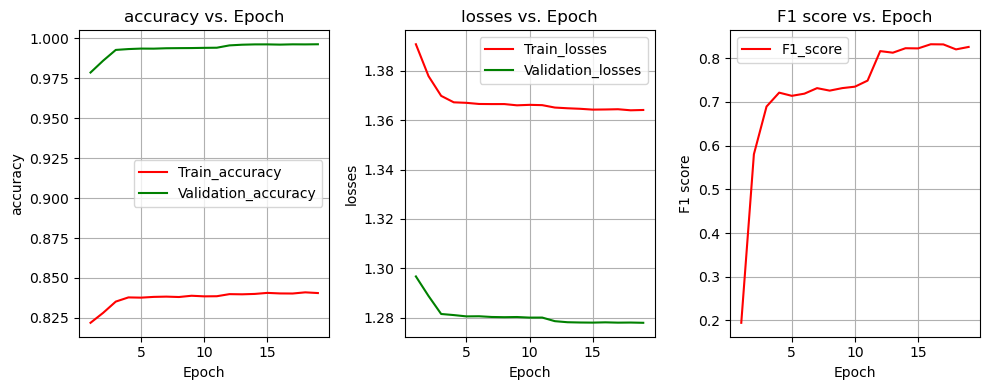

In [36]:
if device.type == 'cuda': torch.cuda.empty_cache() # Release cache

# OPTIMAL parameter found for single LSTM layer
batch_size = 64
hidden_dim = 1024
epoch = 50

# Get dataset loaders
train_data_loader, val_data_loader, train_sentence_len, val_sentence_len = get_training_data(batch_size, ner_label_mapping)
test_data_loader, test_sentence_len = get_test_data(batch_size, ner_label_mapping)

# Initialize EarlyStopper and model
early_stopper = EarlyStopper(patience=3)
model = get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings)

# Train the model
train_accuracies, val_accuracies, train_losses, val_losses, f1_score_arr, time_taken = train_model(model, train_data_loader, 
    val_data_loader, val_sentence_len, device=device, epochs=epoch, weights=None, early_stopper=early_stopper, random_initial_state=False, debug=True)

# Test the model
test_accuracy, f1_score, y_true_tags, y_pred_tags = test_model(model, test_data_loader, test_sentence_len, device)

# Plot findings
plot_findings(len(train_accuracies), [[train_accuracies, val_accuracies], [train_losses, val_losses], [f1_score_arr]], "Epoch", isoptimal=True)

# If want to save model:
# save_model(model, name_='single_lstm.pth')

### 1.1 [Findings] single lstm layer parameters for hidden_dim and batch size
#### Test for optimal batch size using 512 hidden_dim obtained below

 44%|████████████████████████████████████                                              | 22/50 [01:48<02:18,  4.94s/it]

Early stopping at epoch (23) due to no improvement in f1 score.
Time taken for the model to run finish: 108.76 seconds


Results of test model:
Time taken to run finish: 0.45 seconds
F1 score: 0.7632, Test Accuracy: 0.9959


 44%|████████████████████████████████████                                              | 22/50 [01:15<01:36,  3.44s/it]

Early stopping at epoch (23) due to no improvement in f1 score.
Time taken for the model to run finish: 75.78 seconds


Results of test model:
Time taken to run finish: 0.31 seconds
F1 score: 0.7657, Test Accuracy: 0.9961


 50%|█████████████████████████████████████████                                         | 25/50 [01:09<01:09,  2.80s/it]

Early stopping at epoch (26) due to no improvement in f1 score.
Time taken for the model to run finish: 69.93 seconds


Results of test model:
Time taken to run finish: 0.26 seconds
F1 score: 0.7589, Test Accuracy: 0.9960


 44%|████████████████████████████████████                                              | 22/50 [07:52<10:00, 21.46s/it]

Early stopping at epoch (23) due to no improvement in f1 score.
Time taken for the model to run finish: 472.03 seconds


Results of test model:
Time taken to run finish: 0.24 seconds
F1 score: 0.6987, Test Accuracy: 0.9947


 62%|██████████████████████████████████████████████████▊                               | 31/50 [05:45<03:31, 11.14s/it]

Early stopping at epoch (32) due to no improvement in f1 score.
Time taken for the model to run finish: 345.28 seconds


Results of test model:
Time taken to run finish: 0.21 seconds
F1 score: 0.7100, Test Accuracy: 0.9947


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [22:21<00:00, 26.83s/it]


Time taken for the model to run finish: 1341.72 seconds
Results of test model:
Time taken to run finish: 0.48 seconds
F1 score: 0.6924, Test Accuracy: 0.9944
Plot findings of training data


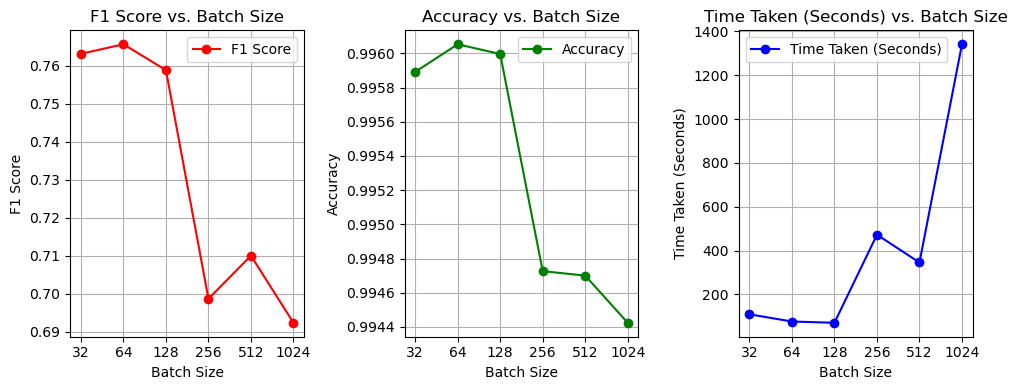

Best f1_score for Batch Size: 64, 0.7656782996588821


In [16]:
if device.type == 'cuda': torch.cuda.empty_cache() # Release cache

# Fixed parameters for this testing
epoch = 50
hidden_dim = 512

# Variable for testing
batch_size = [32,64,128,256,512,1024]
F1_s, acc, tt = [], [], []
for BS in batch_size:
    # Get dataset loaders with different batch size
    train_data_loader, val_data_loader, train_sentence_len, val_sentence_len = get_training_data(BS, ner_label_mapping)
    test_data_loader, test_sentence_len = get_test_data(BS, ner_label_mapping)
    
    # Initialize EarlyStopper and model
    early_stopper = EarlyStopper(patience=3)
    model = get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings)
    
    # Train and test the model on the parameters set
    _,_,_,_, f1_score_arr, time_taken = train_model(model, train_data_loader, val_data_loader, val_sentence_len, device=device, epochs=epoch, weights=None, early_stopper=early_stopper, random_initial_state=False, debug=False)
    test_accuracy, f1_score, _,_ = test_model(model, test_data_loader, test_sentence_len, device)
    F1_s.append(f1_score)
    acc.append(test_accuracy)
    tt.append(time_taken)

# Report findings
plot_findings(batch_size, [F1_s,acc,tt], "Batch Size")
print(f"Best f1_score for Batch Size: {batch_size[F1_s.index(max(F1_s))]}, {max(F1_s)}")

#### Test for optimal hidden_dim using 32 batchsize obtained above

 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:51<00:31,  1.66s/it]

Early stopping at epoch (32) due to no improvement in f1 score.
Time taken for the model to run finish: 51.40 seconds


Results of test model:
Time taken to run finish: 0.13 seconds
F1 score: 0.7449, Test Accuracy: 0.9955


 44%|████████████████████████████████████                                              | 22/50 [00:37<00:47,  1.69s/it]

Early stopping at epoch (23) due to no improvement in f1 score.
Time taken for the model to run finish: 37.10 seconds


Results of test model:
Time taken to run finish: 0.13 seconds
F1 score: 0.7461, Test Accuracy: 0.9958


 32%|██████████████████████████▏                                                       | 16/50 [00:27<00:58,  1.72s/it]

Early stopping at epoch (17) due to no improvement in f1 score.
Time taken for the model to run finish: 27.54 seconds


Results of test model:
Time taken to run finish: 0.13 seconds
F1 score: 0.7101, Test Accuracy: 0.9948


 32%|██████████████████████████▏                                                       | 16/50 [00:27<00:58,  1.72s/it]

Early stopping at epoch (17) due to no improvement in f1 score.
Time taken for the model to run finish: 27.50 seconds


Results of test model:
Time taken to run finish: 0.16 seconds
F1 score: 0.7140, Test Accuracy: 0.9949


 38%|███████████████████████████████▏                                                  | 19/50 [01:25<02:20,  4.52s/it]

Early stopping at epoch (20) due to no improvement in f1 score.
Time taken for the model to run finish: 85.90 seconds


Results of test model:
Time taken to run finish: 0.41 seconds
F1 score: 0.7604, Test Accuracy: 0.9960


 46%|█████████████████████████████████████▋                                            | 23/50 [01:46<02:04,  4.62s/it]

Early stopping at epoch (24) due to no improvement in f1 score.
Time taken for the model to run finish: 106.21 seconds


Results of test model:
Time taken to run finish: 0.43 seconds
F1 score: 0.7563, Test Accuracy: 0.9958


 32%|██████████████████████████▏                                                       | 16/50 [03:03<06:29, 11.45s/it]

Early stopping at epoch (17) due to no improvement in f1 score.
Time taken for the model to run finish: 183.28 seconds


Results of test model:
Time taken to run finish: 1.08 seconds
F1 score: 0.7666, Test Accuracy: 0.9960
Plot findings of training data


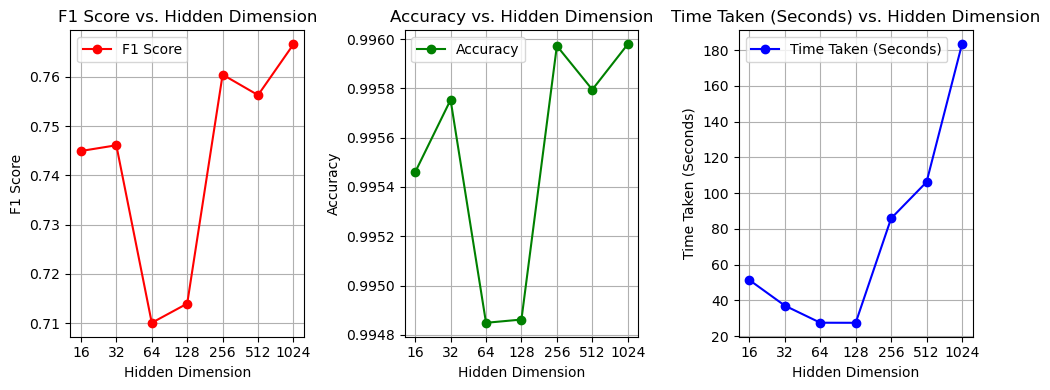

Best f1_score for Hidden Dim: 1024, 0.7665834756337843


In [17]:
if device.type == 'cuda': torch.cuda.empty_cache() # Release cache

# Fixed parameters for this testing
epoch = 50
batch_size = 32

# Get dataset loaders with fixed batch size
train_data_loader, val_data_loader, train_sentence_len, val_sentence_len = get_training_data(batch_size, ner_label_mapping)
test_data_loader, test_sentence_len = get_test_data(batch_size, ner_label_mapping)

# Variable for testing
hidden_dim = [16,32,64,128,256,512,1024]
F1_s, acc, tt = [], [], []
for hd in hidden_dim:
    # Initialize EarlyStopper and model
    early_stopper = EarlyStopper(patience=3)
    model = get_model(embedding_dim, hd, num_labels, pretrained_embeddings)
    
    # Train and test the model on the parameters set
    _,_,_,_, f1_score_arr, time_taken = train_model(model, train_data_loader, val_data_loader, val_sentence_len, device=device, epochs=epoch, weights=None, early_stopper=early_stopper, random_initial_state=False, debug=False)
    test_accuracy, f1_score, _,_ = test_model(model, test_data_loader, test_sentence_len, device)
    F1_s.append(f1_score)
    acc.append(test_accuracy)
    tt.append(time_taken)

# Report findings
plot_findings(hidden_dim, [F1_s,acc,tt], "Hidden Dimension")
print(f"Best f1_score for Hidden Dim: {hidden_dim[F1_s.index(max(F1_s))]}, {max(F1_s)}")

#### Test for optimal hidden_dim using 64 batchsize obtained above

 50%|█████████████████████████████████████████                                         | 25/50 [00:25<00:25,  1.02s/it]

Early stopping at epoch (26) due to no improvement in f1 score.
Time taken for the model to run finish: 25.41 seconds


Results of test model:
Time taken to run finish: 0.08 seconds
F1 score: 0.6782, Test Accuracy: 0.9943


 54%|████████████████████████████████████████████▎                                     | 27/50 [00:27<00:23,  1.01s/it]

Early stopping at epoch (28) due to no improvement in f1 score.
Time taken for the model to run finish: 27.17 seconds


Results of test model:
Time taken to run finish: 0.10 seconds
F1 score: 0.6951, Test Accuracy: 0.9945


 50%|█████████████████████████████████████████                                         | 25/50 [00:25<00:25,  1.01s/it]

Early stopping at epoch (26) due to no improvement in f1 score.
Time taken for the model to run finish: 25.33 seconds


Results of test model:
Time taken to run finish: 0.08 seconds
F1 score: 0.7617, Test Accuracy: 0.9960


 48%|███████████████████████████████████████▎                                          | 24/50 [00:29<00:31,  1.22s/it]

Early stopping at epoch (25) due to no improvement in f1 score.
Time taken for the model to run finish: 29.29 seconds


Results of test model:
Time taken to run finish: 0.12 seconds
F1 score: 0.7215, Test Accuracy: 0.9950


 48%|███████████████████████████████████████▎                                          | 24/50 [01:02<01:07,  2.61s/it]

Early stopping at epoch (25) due to no improvement in f1 score.
Time taken for the model to run finish: 62.58 seconds


Results of test model:
Time taken to run finish: 0.24 seconds
F1 score: 0.7663, Test Accuracy: 0.9959


 36%|█████████████████████████████▌                                                    | 18/50 [00:58<01:44,  3.27s/it]

Early stopping at epoch (19) due to no improvement in f1 score.
Time taken for the model to run finish: 58.95 seconds


Results of test model:
Time taken to run finish: 0.29 seconds
F1 score: 0.7200, Test Accuracy: 0.9950


 18%|██████████████▉                                                                    | 9/50 [01:08<05:11,  7.60s/it]

Early stopping at epoch (10) due to no improvement in f1 score.
Time taken for the model to run finish: 68.36 seconds


Results of test model:
Time taken to run finish: 0.60 seconds
F1 score: 0.7084, Test Accuracy: 0.9947
Plot findings of training data


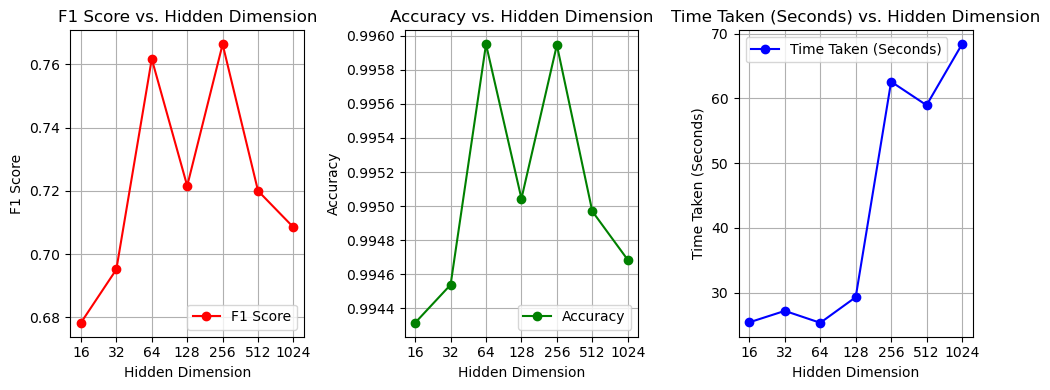

Best f1_score for Hidden Dim: 256, 0.7663306715538684


In [18]:
if device.type == 'cuda': torch.cuda.empty_cache() # Release cache

# Fixed parameters for this testing
epoch = 50
batch_size = 64

# Get dataset loaders with fixed batch size
train_data_loader, val_data_loader, train_sentence_len, val_sentence_len = get_training_data(batch_size, ner_label_mapping)
test_data_loader, test_sentence_len = get_test_data(batch_size, ner_label_mapping)

# Variable for testing
hidden_dim = [16,32,64,128,256,512,1024] 
F1_s, acc, tt = [], [], []
for hd in hidden_dim:
    # Initialize EarlyStopper and model
    early_stopper = EarlyStopper(patience=3)
    model = get_model(embedding_dim, hd, num_labels, pretrained_embeddings)
    
    # Train and test the model on the parameters set
    _,_,_,_, f1_score_arr, time_taken = train_model(model, train_data_loader, val_data_loader, val_sentence_len, device=device, epochs=epoch, weights=None, early_stopper=early_stopper, random_initial_state=False, debug=False)
    test_accuracy, f1_score, _,_ = test_model(model, test_data_loader, test_sentence_len, device)
    F1_s.append(f1_score)
    acc.append(test_accuracy)
    tt.append(time_taken)

# Report findings
plot_findings(hidden_dim, [F1_s,acc,tt], "Hidden Dimension")
print(f"Best f1_score for Hidden Dim: {hidden_dim[F1_s.index(max(F1_s))]}, {max(F1_s)}")

---
## 2. [Optimal] Double stacked LSTM layer

  2%|█▋                                                                                 | 1/50 [00:23<19:05, 23.37s/it]

Epoch 1.00, F1 Score: 0.1884, Time taken for this epoch: 23.37s.
             Train Loss: 1.3835, Val Loss: 1.2942, Train Accuracy: 0.8247, Validation Accuracy: 0.9799.



  4%|███▎                                                                               | 2/50 [00:46<18:42, 23.38s/it]

Epoch 2.00, F1 Score: 0.7057, Time taken for this epoch: 23.39s.
             Train Loss: 1.3695, Val Loss: 1.2811, Train Accuracy: 0.8357, Validation Accuracy: 0.9929.



  6%|████▉                                                                              | 3/50 [01:10<18:19, 23.38s/it]

Epoch 3.00, F1 Score: 0.7246, Time taken for this epoch: 23.38s.
             Train Loss: 1.3673, Val Loss: 1.2807, Train Accuracy: 0.8374, Validation Accuracy: 0.9934.



  8%|██████▋                                                                            | 4/50 [01:33<17:55, 23.38s/it]

Epoch 4.00, F1 Score: 0.7131, Time taken for this epoch: 23.37s.
             Train Loss: 1.3674, Val Loss: 1.2811, Train Accuracy: 0.8373, Validation Accuracy: 0.9928.



 10%|████████▎                                                                          | 5/50 [01:56<17:32, 23.39s/it]

Epoch 5.00, F1 Score: 0.7289, Time taken for this epoch: 23.40s.
             Train Loss: 1.3669, Val Loss: 1.2803, Train Accuracy: 0.8378, Validation Accuracy: 0.9936.



 12%|█████████▉                                                                         | 6/50 [02:20<17:10, 23.41s/it]

Epoch 6.00, F1 Score: 0.7406, Time taken for this epoch: 23.46s.
             Train Loss: 1.3664, Val Loss: 1.2802, Train Accuracy: 0.8383, Validation Accuracy: 0.9938.



 14%|███████████▌                                                                       | 7/50 [02:43<16:48, 23.45s/it]

Epoch 7.00, F1 Score: 0.7426, Time taken for this epoch: 23.52s.
             Train Loss: 1.3662, Val Loss: 1.2802, Train Accuracy: 0.8386, Validation Accuracy: 0.9938.



 16%|█████████████▎                                                                     | 8/50 [03:07<16:25, 23.47s/it]

Epoch 8.00, F1 Score: 0.7309, Time taken for this epoch: 23.50s.
             Train Loss: 1.3661, Val Loss: 1.2802, Train Accuracy: 0.8387, Validation Accuracy: 0.9938.



 18%|██████████████▉                                                                    | 9/50 [03:30<16:01, 23.46s/it]

Epoch 9.00, F1 Score: 0.7374, Time taken for this epoch: 23.44s.
             Train Loss: 1.3663, Val Loss: 1.2801, Train Accuracy: 0.8382, Validation Accuracy: 0.9939.



 18%|██████████████▉                                                                    | 9/50 [03:54<17:49, 26.07s/it]

Epoch 10.00, F1 Score: 0.7328, Time taken for this epoch: 23.81s.
             Train Loss: 1.3659, Val Loss: 1.2801, Train Accuracy: 0.8390, Validation Accuracy: 0.9939.
Early stopping at epoch (10) due to no improvement in f1 score.
Time taken for the model to run finish: 234.66 seconds


Results of test model:
Time taken to run finish: 2.27 seconds
F1 score: 0.7305, Test Accuracy: 0.9949
Plot findings of training data


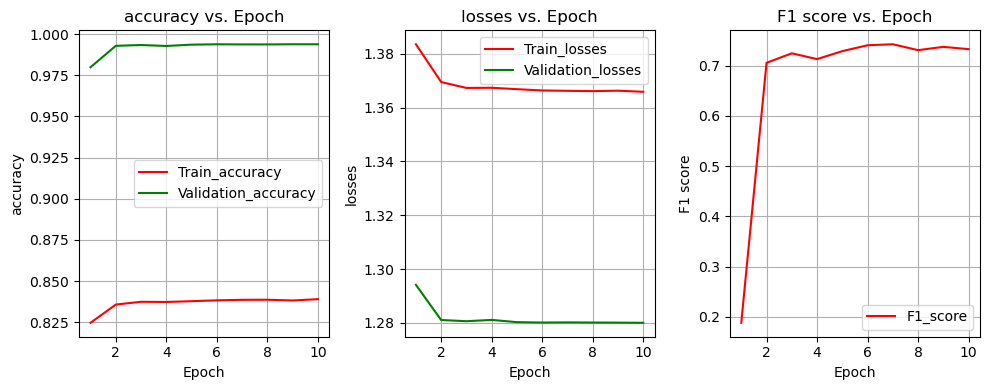

In [33]:
class NERModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_labels, pretrained_embeddings, dropout_prob=0.2):
        super(NERModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)  # Freeze the embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, num_labels)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x, random_initial_state=False):    
        embedded_x = self.embedding(x)
        
        if random_initial_state:
            # Utilize random initial state
            h0 = torch.randn(1, embedded_x.size(0), self.hidden_dim).to(device)
            c0 = torch.randn(1, embedded_x.size(0), self.hidden_dim).to(device)
            lstm_out, (h_0,c_0) = self.lstm(embedded_x, (h0,c0))
            lstm2_out, _ = self.lstm2(lstm_out, (h_0,c_0))
        else:
            # Utilize Zero initial state
            lstm_out, _ = self.lstm(embedded_x)
            lstm2_out, _ = self.lstm2(lstm_out)
            
        logits = self.linear(lstm2_out)
        drop_out = self.dropout(logits)
        output = self.softmax(drop_out)
        return output

if device.type == 'cuda': torch.cuda.empty_cache() # Release cache

# OPTIMAL parameter found for double stacked LSTM layer
batch_size = 32
hidden_dim = 1024
epoch = 50

# Get dataset loaders
train_data_loader, val_data_loader, train_sentence_len, val_sentence_len = get_training_data(batch_size, ner_label_mapping)
test_data_loader, test_sentence_len = get_test_data(batch_size, ner_label_mapping)

# Initialize EarlyStopper and model
early_stopper = EarlyStopper(patience=3)
model = get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings)

# Train the model
train_accuracies, val_accuracies, train_losses, val_losses, f1_score_arr, time_taken = train_model(model, train_data_loader, 
    val_data_loader, val_sentence_len, device=device, epochs=epoch, weights=None, early_stopper=early_stopper, random_initial_state=False, debug=True)

# Test the model
test_accuracy, f1_score, y_true_tags, y_pred_tags = test_model(model, test_data_loader, test_sentence_len, device)

# Plot findings
plot_findings(len(train_accuracies), [[train_accuracies, val_accuracies], [train_losses, val_losses], [f1_score_arr]], "Epoch", isoptimal=True)

# If want to save model:
# save_model(model, name_='double_lstm.pth')

### 2.1 [Findings] Double stacked LSTM layer parameters for hidden_dim and batch size
#### Test for optimal batch size using hidden dimension of 512 obtained below

 18%|██████████████▉                                                                    | 9/50 [01:13<05:35,  8.18s/it]

Early stopping at epoch (10) due to no improvement in f1 score.
Time taken for the model to run finish: 73.62 seconds


Results of test model:
Time taken to run finish: 0.73 seconds
F1 score: 0.7117, Test Accuracy: 0.9948


 28%|██████████████████████▉                                                           | 14/50 [01:01<02:39,  4.42s/it]

Early stopping at epoch (15) due to no improvement in f1 score.
Time taken for the model to run finish: 61.92 seconds


Results of test model:
Time taken to run finish: 0.40 seconds
F1 score: 0.7107, Test Accuracy: 0.9948


 44%|████████████████████████████████████                                              | 22/50 [00:56<01:11,  2.55s/it]

Early stopping at epoch (23) due to no improvement in f1 score.
Time taken for the model to run finish: 56.03 seconds


Results of test model:
Time taken to run finish: 0.23 seconds
F1 score: 0.7070, Test Accuracy: 0.9947


 50%|█████████████████████████████████████████                                         | 25/50 [00:52<00:52,  2.10s/it]

Early stopping at epoch (26) due to no improvement in f1 score.
Time taken for the model to run finish: 52.59 seconds


Results of test model:
Time taken to run finish: 0.18 seconds
F1 score: 0.6988, Test Accuracy: 0.9947


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:20<00:17,  1.97s/it]

Early stopping at epoch (42) due to no improvement in f1 score.
Time taken for the model to run finish: 80.71 seconds


Results of test model:
Time taken to run finish: 0.17 seconds
F1 score: 0.6970, Test Accuracy: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [16:42<00:00, 20.05s/it]


Time taken for the model to run finish: 1002.63 seconds
Results of test model:
Time taken to run finish: 0.16 seconds
F1 score: 0.5312, Test Accuracy: 0.9895
Plot findings of training data


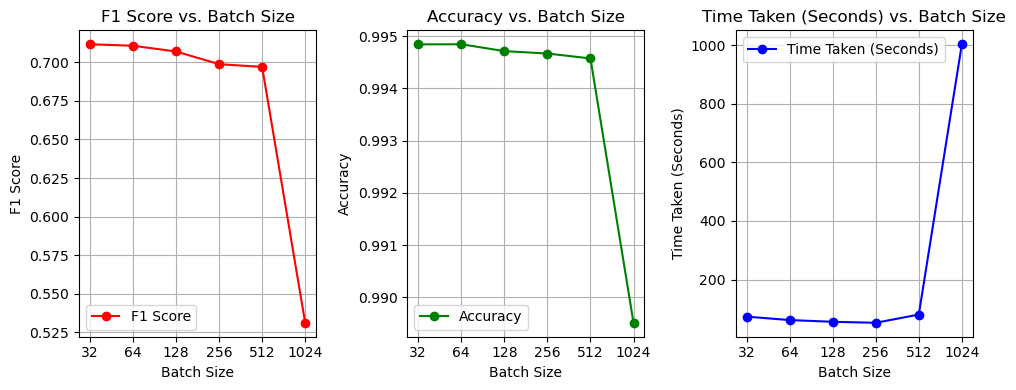

Best f1_score for Batch Size: 32, 0.7117153138744502


In [20]:
if device.type == 'cuda': torch.cuda.empty_cache() # Release cache
    
# Fixed parameters for this testing
epoch = 50
hidden_dim = 256

# Variable for testing
F1_s, acc, tt = [], [], []
batch_size = [32,64,128,256,512,1024]
for BS in batch_size:
    
    # Get dataset loaders with different batch size
    train_data_loader, val_data_loader, train_sentence_len, val_sentence_len = get_training_data(BS, ner_label_mapping)
    test_data_loader, test_sentence_len = get_test_data(BS, ner_label_mapping)
    
    # Initialize EarlyStopper and model
    early_stopper = EarlyStopper(patience=3)
    model = get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings)
    
    # Train and test the model on the parameters set
    _,_,_,_, f1_score_arr, time_taken = train_model(model, train_data_loader, val_data_loader, val_sentence_len, device=device, epochs=epoch, weights=None, early_stopper=early_stopper, random_initial_state=False, debug=False)
    test_accuracy, f1_score, _,_ = test_model(model, test_data_loader, test_sentence_len, device)
    F1_s.append(f1_score)
    acc.append(test_accuracy)
    tt.append(time_taken)
    
# Report findings
plot_findings(batch_size, [F1_s,acc,tt], "Batch Size")
print(f"Best f1_score for Batch Size: {batch_size[F1_s.index(max(F1_s))]}, {max(F1_s)}")

#### Test for optimal hidden_dim using 32 batchsize obtained above

 44%|████████████████████████████████████                                              | 22/50 [00:47<01:00,  2.17s/it]

Early stopping at epoch (23) due to no improvement in f1 score.
Time taken for the model to run finish: 47.80 seconds


Results of test model:
Time taken to run finish: 0.18 seconds
F1 score: 0.7088, Test Accuracy: 0.9947


 46%|█████████████████████████████████████▋                                            | 23/50 [00:50<00:58,  2.18s/it]

Early stopping at epoch (24) due to no improvement in f1 score.
Time taken for the model to run finish: 50.06 seconds


Results of test model:
Time taken to run finish: 0.17 seconds
F1 score: 0.7148, Test Accuracy: 0.9947


 24%|███████████████████▋                                                              | 12/50 [00:26<01:25,  2.25s/it]

Early stopping at epoch (13) due to no improvement in f1 score.
Time taken for the model to run finish: 26.97 seconds


Results of test model:
Time taken to run finish: 0.17 seconds
F1 score: 0.7047, Test Accuracy: 0.9947


 28%|██████████████████████▉                                                           | 14/50 [00:31<01:21,  2.28s/it]


Early stopping at epoch (15) due to no improvement in f1 score.
Time taken for the model to run finish: 31.86 seconds
Results of test model:
Time taken to run finish: 0.24 seconds
F1 score: 0.7068, Test Accuracy: 0.9947


 38%|███████████████████████████████▏                                                  | 19/50 [02:31<04:07,  8.00s/it]

Early stopping at epoch (20) due to no improvement in f1 score.
Time taken for the model to run finish: 151.99 seconds


Results of test model:
Time taken to run finish: 0.78 seconds
F1 score: 0.7166, Test Accuracy: 0.9949


 36%|█████████████████████████████▌                                                    | 18/50 [02:37<04:39,  8.73s/it]

Early stopping at epoch (19) due to no improvement in f1 score.
Time taken for the model to run finish: 157.21 seconds


Results of test model:
Time taken to run finish: 0.78 seconds
F1 score: 0.7204, Test Accuracy: 0.9950


 36%|█████████████████████████████▌                                                    | 18/50 [07:28<13:17, 24.92s/it]

Early stopping at epoch (19) due to no improvement in f1 score.
Time taken for the model to run finish: 448.64 seconds


Results of test model:
Time taken to run finish: 2.26 seconds
F1 score: 0.7217, Test Accuracy: 0.9949
Plot findings of training data


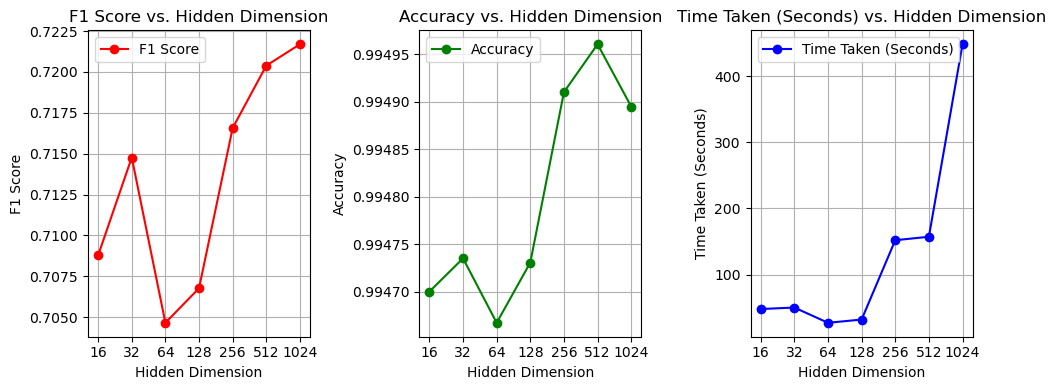

Best f1_score for Hidden Dim: 1024, 0.7216936888650677


In [32]:
if device.type == 'cuda': torch.cuda.empty_cache() # Release cache

# Fixed parameters for this testing
epoch = 50
batch_size = 32

# Get dataset loaders with fixed batch size
train_data_loader, val_data_loader, train_sentence_len, val_sentence_len = get_training_data(batch_size, ner_label_mapping)
test_data_loader, test_sentence_len = get_test_data(batch_size, ner_label_mapping)

# Variable for testing
hidden_dim = [16,32,64,128,256,512,1024] # Change to see if there are any improvements
F1_s, acc, tt = [], [], []
for hd in hidden_dim:
    # Initialize EarlyStopper and model
    early_stopper = EarlyStopper(patience=3)
    model = get_model(embedding_dim, hd, num_labels, pretrained_embeddings)
    
    # Train and test the model on the parameters set
    _,_,_,_, f1_score_arr, time_taken = train_model(model, train_data_loader, val_data_loader, val_sentence_len, device=device, epochs=epoch, weights=None, early_stopper=early_stopper, random_initial_state=False, debug=False)
    test_accuracy, f1_score, _,_ = test_model(model, test_data_loader, test_sentence_len, device)
    F1_s.append(f1_score)
    acc.append(test_accuracy)
    tt.append(time_taken)
    
# Report findings
plot_findings(hidden_dim, [F1_s,acc,tt], "Hidden Dimension")
print(f"Best f1_score for Hidden Dim: {hidden_dim[F1_s.index(max(F1_s))]}, {max(F1_s)}")

---
## 3. [Optimal] Multi-head self-attention

In [38]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, input_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        assert input_dim % num_heads == 0 # Ensure that the input_dim are divisable by num_heads
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads

        self.W_q = nn.ModuleList([nn.Linear(input_dim, self.head_dim) for _ in range(num_heads)])
        self.W_k = nn.ModuleList([nn.Linear(input_dim, self.head_dim) for _ in range(num_heads)])
        self.W_v = nn.ModuleList([nn.Linear(input_dim, self.head_dim) for _ in range(num_heads)])
        self.W_o = nn.Linear(input_dim, input_dim)

    def forward(self, input_seq):
        batch_size = input_seq.size(0)
        head_outputs = []

        for i in range(self.num_heads):
            q = self.W_q[i](input_seq)
            k = self.W_k[i](input_seq)
            v = self.W_v[i](input_seq)

            attn_scores = torch.matmul(q, k.transpose(-1, -2)) / (q.size(-1) ** 0.5)
            attn_probs = nn.functional.softmax(attn_scores, dim=-1)
            output = torch.matmul(attn_probs, v)
            head_outputs.append(output)
        multi_head_output = torch.cat(head_outputs, dim=-1)
        output = self.W_o(multi_head_output)
        return output

class NERAttentionModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_labels, pretrained_embeddings, dropout_prob=0.2, num_heads=4):
        super(NERAttentionModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        self.multihead_attention = MultiHeadSelfAttention(embedding_dim, num_heads)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, num_labels)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x, random_initial_state=False):    
        embedded_x = self.embedding(x)
        multi_head_out = self.multihead_attention(embedded_x)
        lstm_out, _ = self.lstm(multi_head_out)
        logits = self.linear(lstm_out)
        drop_out = self.dropout(logits)
        output = self.softmax(drop_out)
        return output

def get_attention_ner_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings):
    return NERAttentionModel(embedding_dim, hidden_dim, num_labels, pretrained_embeddings)

  2%|█▋                                                                                 | 1/50 [00:04<03:34,  4.38s/it]

Epoch 1.00, F1 Score: 0.0000, Time taken for this epoch: 4.38s.
             Train Loss: 1.3924, Val Loss: 1.2965, Train Accuracy: 0.8216, Validation Accuracy: 0.9772.



  4%|███▎                                                                               | 2/50 [00:08<03:28,  4.33s/it]

Epoch 2.00, F1 Score: 0.0000, Time taken for this epoch: 4.30s.
             Train Loss: 1.3796, Val Loss: 1.2968, Train Accuracy: 0.8256, Validation Accuracy: 0.9772.



  6%|████▉                                                                              | 3/50 [00:12<03:23,  4.32s/it]

Epoch 3.00, F1 Score: 0.0000, Time taken for this epoch: 4.30s.
             Train Loss: 1.3799, Val Loss: 1.2966, Train Accuracy: 0.8250, Validation Accuracy: 0.9772.



  8%|██████▋                                                                            | 4/50 [00:17<03:18,  4.31s/it]

Epoch 4.00, F1 Score: 0.0000, Time taken for this epoch: 4.30s.
             Train Loss: 1.3798, Val Loss: 1.2967, Train Accuracy: 0.8250, Validation Accuracy: 0.9772.



 10%|████████▎                                                                          | 5/50 [00:21<03:14,  4.31s/it]

Epoch 5.00, F1 Score: 0.0060, Time taken for this epoch: 4.32s.
             Train Loss: 1.3795, Val Loss: 1.2966, Train Accuracy: 0.8255, Validation Accuracy: 0.9773.



 12%|█████████▉                                                                         | 6/50 [00:25<03:09,  4.31s/it]

Epoch 6.00, F1 Score: 0.1981, Time taken for this epoch: 4.31s.
             Train Loss: 1.3790, Val Loss: 1.2955, Train Accuracy: 0.8262, Validation Accuracy: 0.9783.



 14%|███████████▌                                                                       | 7/50 [00:30<03:05,  4.32s/it]

Epoch 7.00, F1 Score: 0.3474, Time taken for this epoch: 4.32s.
             Train Loss: 1.3759, Val Loss: 1.2889, Train Accuracy: 0.8291, Validation Accuracy: 0.9849.



 16%|█████████████▎                                                                     | 8/50 [00:34<03:01,  4.32s/it]

Epoch 8.00, F1 Score: 0.5818, Time taken for this epoch: 4.33s.
             Train Loss: 1.3714, Val Loss: 1.2842, Train Accuracy: 0.8336, Validation Accuracy: 0.9898.



 18%|██████████████▉                                                                    | 9/50 [00:38<02:56,  4.32s/it]

Epoch 9.00, F1 Score: 0.6645, Time taken for this epoch: 4.31s.
             Train Loss: 1.3692, Val Loss: 1.2824, Train Accuracy: 0.8356, Validation Accuracy: 0.9915.



 20%|████████████████▍                                                                 | 10/50 [00:43<02:52,  4.31s/it]

Epoch 10.00, F1 Score: 0.6840, Time taken for this epoch: 4.31s.
             Train Loss: 1.3682, Val Loss: 1.2819, Train Accuracy: 0.8366, Validation Accuracy: 0.9920.



 22%|██████████████████                                                                | 11/50 [00:47<02:48,  4.32s/it]

Epoch 11.00, F1 Score: 0.6772, Time taken for this epoch: 4.33s.
             Train Loss: 1.3678, Val Loss: 1.2816, Train Accuracy: 0.8371, Validation Accuracy: 0.9923.



 24%|███████████████████▋                                                              | 12/50 [00:52<02:46,  4.38s/it]

Epoch 12.00, F1 Score: 0.6854, Time taken for this epoch: 4.50s.
             Train Loss: 1.3674, Val Loss: 1.2814, Train Accuracy: 0.8373, Validation Accuracy: 0.9926.



 26%|█████████████████████▎                                                            | 13/50 [00:56<02:41,  4.36s/it]

Epoch 13.00, F1 Score: 0.6862, Time taken for this epoch: 4.32s.
             Train Loss: 1.3669, Val Loss: 1.2812, Train Accuracy: 0.8382, Validation Accuracy: 0.9927.



 28%|██████████████████████▉                                                           | 14/50 [01:00<02:36,  4.34s/it]

Epoch 14.00, F1 Score: 0.6883, Time taken for this epoch: 4.29s.
             Train Loss: 1.3673, Val Loss: 1.2812, Train Accuracy: 0.8373, Validation Accuracy: 0.9928.



 30%|████████████████████████▌                                                         | 15/50 [01:04<02:31,  4.34s/it]

Epoch 15.00, F1 Score: 0.6986, Time taken for this epoch: 4.34s.
             Train Loss: 1.3667, Val Loss: 1.2810, Train Accuracy: 0.8383, Validation Accuracy: 0.9930.



 32%|██████████████████████████▏                                                       | 16/50 [01:09<02:27,  4.34s/it]

Epoch 16.00, F1 Score: 0.6947, Time taken for this epoch: 4.34s.
             Train Loss: 1.3668, Val Loss: 1.2808, Train Accuracy: 0.8380, Validation Accuracy: 0.9930.



 34%|███████████████████████████▉                                                      | 17/50 [01:13<02:22,  4.33s/it]

Epoch 17.00, F1 Score: 0.6998, Time taken for this epoch: 4.30s.
             Train Loss: 1.3670, Val Loss: 1.2809, Train Accuracy: 0.8375, Validation Accuracy: 0.9931.



 36%|█████████████████████████████▌                                                    | 18/50 [01:17<02:18,  4.32s/it]

Epoch 18.00, F1 Score: 0.7087, Time taken for this epoch: 4.31s.
             Train Loss: 1.3669, Val Loss: 1.2810, Train Accuracy: 0.8377, Validation Accuracy: 0.9931.



 38%|███████████████████████████████▏                                                  | 19/50 [01:22<02:13,  4.31s/it]

Epoch 19.00, F1 Score: 0.7076, Time taken for this epoch: 4.30s.
             Train Loss: 1.3664, Val Loss: 1.2809, Train Accuracy: 0.8384, Validation Accuracy: 0.9931.



 40%|████████████████████████████████▊                                                 | 20/50 [01:26<02:09,  4.31s/it]

Epoch 20.00, F1 Score: 0.7127, Time taken for this epoch: 4.31s.
             Train Loss: 1.3668, Val Loss: 1.2808, Train Accuracy: 0.8378, Validation Accuracy: 0.9932.



 42%|██████████████████████████████████▍                                               | 21/50 [01:30<02:04,  4.31s/it]

Epoch 21.00, F1 Score: 0.7180, Time taken for this epoch: 4.30s.
             Train Loss: 1.3666, Val Loss: 1.2808, Train Accuracy: 0.8380, Validation Accuracy: 0.9933.



 44%|████████████████████████████████████                                              | 22/50 [01:35<02:00,  4.31s/it]

Epoch 22.00, F1 Score: 0.7157, Time taken for this epoch: 4.30s.
             Train Loss: 1.3664, Val Loss: 1.2807, Train Accuracy: 0.8384, Validation Accuracy: 0.9933.



 46%|█████████████████████████████████████▋                                            | 23/50 [01:39<01:56,  4.31s/it]

Epoch 23.00, F1 Score: 0.7219, Time taken for this epoch: 4.30s.
             Train Loss: 1.3665, Val Loss: 1.2807, Train Accuracy: 0.8383, Validation Accuracy: 0.9934.



 48%|███████████████████████████████████████▎                                          | 24/50 [01:43<01:51,  4.30s/it]

Epoch 24.00, F1 Score: 0.7214, Time taken for this epoch: 4.29s.
             Train Loss: 1.3661, Val Loss: 1.2806, Train Accuracy: 0.8387, Validation Accuracy: 0.9934.



 50%|█████████████████████████████████████████                                         | 25/50 [01:48<01:47,  4.31s/it]

Epoch 25.00, F1 Score: 0.7179, Time taken for this epoch: 4.31s.
             Train Loss: 1.3664, Val Loss: 1.2806, Train Accuracy: 0.8382, Validation Accuracy: 0.9934.



 50%|█████████████████████████████████████████                                         | 25/50 [01:52<01:52,  4.49s/it]

Epoch 26.00, F1 Score: 0.7201, Time taken for this epoch: 4.32s.
             Train Loss: 1.3661, Val Loss: 1.2807, Train Accuracy: 0.8387, Validation Accuracy: 0.9933.
Early stopping at epoch (26) due to no improvement in f1 score.
Time taken for the model to run finish: 112.36 seconds


Results of test model:
Time taken to run finish: 0.39 seconds
F1 score: 0.7231, Test Accuracy: 0.9945
Plot findings of training data


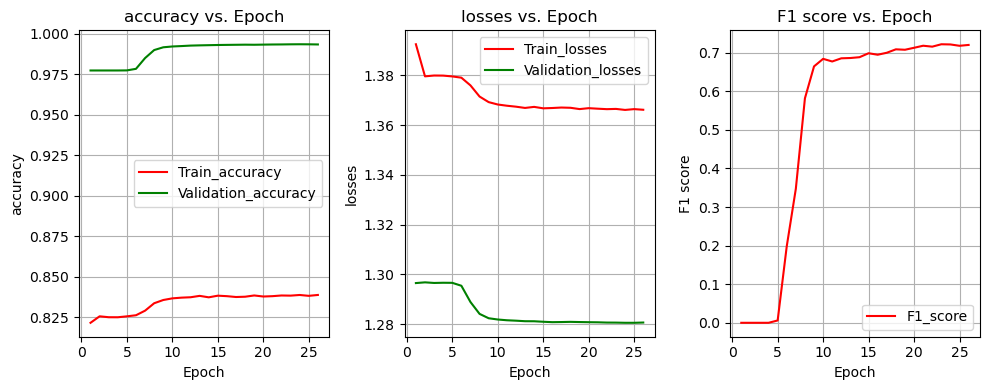

In [42]:
if device.type == 'cuda': torch.cuda.empty_cache() # Release cache

batch_size = 64
hidden_dim = 512
epoch = 50

# Get dataset loaders
train_data_loader, val_data_loader, train_sentence_len, val_sentence_len = get_training_data(batch_size, ner_label_mapping)
test_data_loader, test_sentence_len = get_test_data(batch_size, ner_label_mapping)

# Initialize EarlyStopper and model
early_stopper = EarlyStopper(patience=3)
model = get_attention_ner_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings)

# Train the model
train_accuracies, val_accuracies, train_losses, val_losses, f1_score_arr, time_taken = train_model(model, train_data_loader, 
    val_data_loader, val_sentence_len, device=device, epochs=epoch, weights=None, early_stopper=early_stopper, random_initial_state=False, debug=True)

# Test the model
test_accuracy, f1_score, y_true_tags, y_pred_tags = test_model(model, test_data_loader, test_sentence_len, device)

# Plot findings
plot_findings(len(train_accuracies), [[train_accuracies, val_accuracies], [train_losses, val_losses], [f1_score_arr]], "Epoch", isoptimal=True)

# If want to save model:
# save_model(model, name_='attention_lstm.pth')

### 3.1 [Findings] Multi-head self-attention parameters for hidden_dim and batch size
#### Test for optimal batch size using hidden dimension of 512 obtained below

 38%|███████████████████████████████▏                                                  | 19/50 [02:06<03:27,  6.68s/it]

Early stopping at epoch (20) due to no improvement in f1 score.
Time taken for the model to run finish: 126.96 seconds


Results of test model:
Time taken to run finish: 0.61 seconds
F1 score: 0.6975, Test Accuracy: 0.9943


 46%|█████████████████████████████████████▋                                            | 23/50 [01:39<01:57,  4.34s/it]

Early stopping at epoch (24) due to no improvement in f1 score.
Time taken for the model to run finish: 99.82 seconds


Results of test model:
Time taken to run finish: 0.38 seconds
F1 score: 0.7144, Test Accuracy: 0.9946


 50%|█████████████████████████████████████████                                         | 25/50 [01:32<01:32,  3.68s/it]

Early stopping at epoch (26) due to no improvement in f1 score.
Time taken for the model to run finish: 92.02 seconds


Results of test model:
Time taken to run finish: 0.34 seconds
F1 score: 0.7081, Test Accuracy: 0.9943


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:41<00:22,  3.68s/it]

Early stopping at epoch (45) due to no improvement in f1 score.
Time taken for the model to run finish: 161.80 seconds


Results of test model:
Time taken to run finish: 0.34 seconds
F1 score: 0.7029, Test Accuracy: 0.9945


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [19:30<00:00, 23.41s/it]


Time taken for the model to run finish: 1170.33 seconds
Results of test model:
Time taken to run finish: 0.33 seconds
F1 score: 0.6847, Test Accuracy: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [36:22<00:00, 43.65s/it]


Time taken for the model to run finish: 2182.27 seconds
Results of test model:
Time taken to run finish: 2.92 seconds
F1 score: 0.0000, Test Accuracy: 0.9822
Plot findings of training data


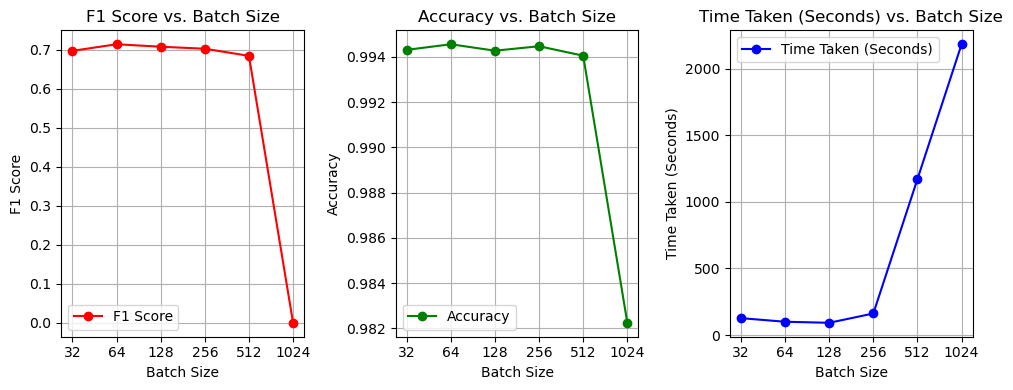

Best f1_score for Batch Size: 64, 0.7144402379664685


In [41]:
if device.type == 'cuda': torch.cuda.empty_cache() # Release cache
    
# Fixed parameters for this testing
epoch = 50
hidden_dim = 512

# Variable for testing
F1_s, acc, tt = [], [], []
batch_size = [32,64,128,256,512,1024]
for BS in batch_size:
    
    # Get dataset loaders with different batch size
    train_data_loader, val_data_loader, train_sentence_len, val_sentence_len = get_training_data(BS, ner_label_mapping)
    test_data_loader, test_sentence_len = get_test_data(BS, ner_label_mapping)
    
    # Initialize EarlyStopper and model
    early_stopper = EarlyStopper(patience=3)
    model = get_attention_ner_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings)
    
    # Train and test the model on the parameters set
    _,_,_,_, f1_score_arr, time_taken = train_model(model, train_data_loader, val_data_loader, val_sentence_len, device=device, epochs=epoch, weights=None, early_stopper=early_stopper, random_initial_state=False, debug=False)
    test_accuracy, f1_score, _,_ = test_model(model, test_data_loader, test_sentence_len, device)
    F1_s.append(f1_score)
    acc.append(test_accuracy)
    tt.append(time_taken)
    
# Report findings
plot_findings(batch_size, [F1_s,acc,tt], "Batch Size")
print(f"Best f1_score for Batch Size: {batch_size[F1_s.index(max(F1_s))]}, {max(F1_s)}")

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:27<00:00,  4.14s/it]


Time taken for the model to run finish: 207.23 seconds
Results of test model:
Time taken to run finish: 0.35 seconds
F1 score: 0.0000, Test Accuracy: 0.9822


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:26<00:00,  4.13s/it]


Time taken for the model to run finish: 206.49 seconds
Results of test model:
Time taken to run finish: 0.28 seconds
F1 score: 0.0000, Test Accuracy: 0.9822


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:26<00:00,  4.13s/it]


Time taken for the model to run finish: 206.65 seconds
Results of test model:
Time taken to run finish: 0.32 seconds
F1 score: 0.0000, Test Accuracy: 0.9822


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:27<00:00,  4.15s/it]


Time taken for the model to run finish: 207.27 seconds
Results of test model:
Time taken to run finish: 0.36 seconds
F1 score: 0.0000, Test Accuracy: 0.9822


 20%|████████████████▍                                                                 | 10/50 [01:14<04:57,  7.45s/it]

Early stopping at epoch (11) due to no improvement in f1 score.
Time taken for the model to run finish: 74.46 seconds


Results of test model:
Time taken to run finish: 0.62 seconds
F1 score: 0.1811, Test Accuracy: 0.9830


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [04:19<01:13,  6.64s/it]

Early stopping at epoch (40) due to no improvement in f1 score.
Time taken for the model to run finish: 259.09 seconds


Results of test model:
Time taken to run finish: 0.64 seconds
F1 score: 0.7604, Test Accuracy: 0.9955


 32%|██████████████████████████▏                                                       | 16/50 [03:37<07:42, 13.61s/it]

Early stopping at epoch (17) due to no improvement in f1 score.
Time taken for the model to run finish: 217.81 seconds


Results of test model:
Time taken to run finish: 1.27 seconds
F1 score: 0.7106, Test Accuracy: 0.9945
Plot findings of training data


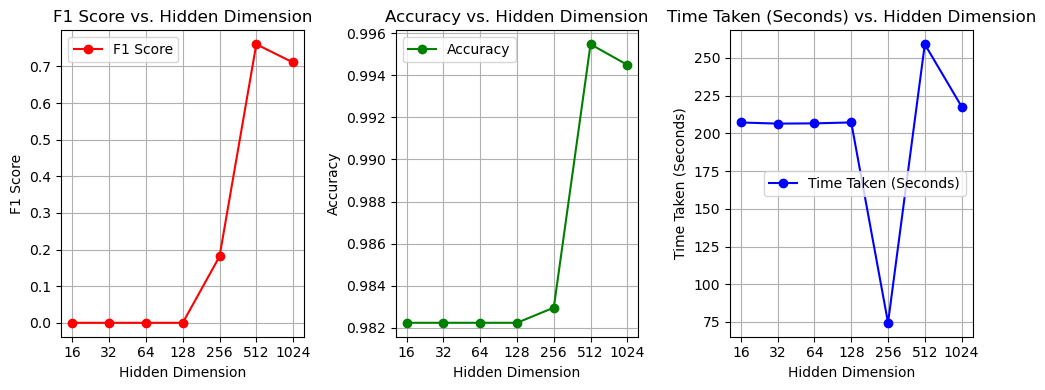

Best f1_score for Hidden Dim: 512, 0.7603656113392503


In [40]:
if device.type == 'cuda': torch.cuda.empty_cache() # Release cache

# Fixed parameters for this testing
epoch = 50
batch_size = 32

# Get dataset loaders with fixed batch size
train_data_loader, val_data_loader, train_sentence_len, val_sentence_len = get_training_data(batch_size, ner_label_mapping)
test_data_loader, test_sentence_len = get_test_data(batch_size, ner_label_mapping)

# Variable for testing
hidden_dim = [16,32,64,128,256,512,1024] # Change to see if there are any improvements
F1_s, acc, tt = [], [], []
for hd in hidden_dim:
    # Initialize EarlyStopper and model
    early_stopper = EarlyStopper(patience=3)
    model = get_attention_ner_model(embedding_dim, hd, num_labels, pretrained_embeddings)
    
    # Train and test the model on the parameters set
    _,_,_,_, f1_score_arr, time_taken = train_model(model, train_data_loader, val_data_loader, val_sentence_len, device=device, epochs=epoch, weights=None, early_stopper=early_stopper, random_initial_state=False, debug=False)
    test_accuracy, f1_score, _,_ = test_model(model, test_data_loader, test_sentence_len, device)
    F1_s.append(f1_score)
    acc.append(test_accuracy)
    tt.append(time_taken)
    
# Report findings
plot_findings(hidden_dim, [F1_s,acc,tt], "Hidden Dimension")
print(f"Best f1_score for Hidden Dim: {hidden_dim[F1_s.index(max(F1_s))]}, {max(F1_s)}")

# Part 2 Sentence-Level Categorization: Question Classification

Import all relevant libraries


In [1]:
import gensim.downloader
import numpy as np
import pandas as pd
import tqdm
import time
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict
import matplotlib.pyplot as plt

# Download the embeddings "word2vec-google-news-300"
w2v = gensim.downloader.load('word2vec-google-news-300')

## Let us first pre-process the dataset, and create a development set


In [2]:
# Create a seed for reproducibility
random_seed = 11

### Create train_df,validation_df and test_df, where validation_df has 500 examples extracted from original_train_df

In [3]:
# Define the file paths
train_file = "data/Part 2/train.csv"
test_file = "data/Part 2/test.csv"

# Load the original training data
original_train_df = pd.read_csv(train_file)

# Split the original training data into train and validation sets
train_df, validation_df = train_test_split(original_train_df, test_size=500, random_state=random_seed)

# Load the test data
test_df = pd.read_csv(test_file)

In [4]:
print("Original shape:   ", original_train_df.shape)
print("Training shape:   ", train_df.shape)
print("Validation shape: ", validation_df.shape)
print("Test shape:\t  ", test_df.shape)

Original shape:    (5452, 3)
Training shape:    (4952, 3)
Validation shape:  (500, 3)
Test shape:	   (500, 3)


### Randomly select 4 class from the 6 different coarse labels and combine the remaing labels to form a single class 'OTHERS'


In [5]:
# Column name   	 Description
# label-coarse  	 The coarse-grained label for the question. (String)
# label-fine    	 The fine-grained label for the question. (String)
# text          	 The text of the question. (String)
# We will be focusing on the label-coarse, to use RNNs approach for classification of question labels.
train_df

,label-coarse,label-fine,text
483,3,4,"Who came up with the name , El Nino ?"
2237,5,14,What river is Pocahontas buried along ?
605,1,19,What color of dry wine should be served with v...
2026,4,13,What is the population in India ?
1478,3,4,Who won the 1967 Academy Award for Best Actor ?
...,...,...,...
1293,5,24,What is the world 's highest peak ?
4023,3,4,What Batman character tools around on a Batcyc...
5200,1,10,What are some science fair projects for 8th gr...
3775,0,0,How does food color affect how you think it wi...


In [6]:
train_df['label-coarse'].value_counts()

label-coarse
1    1139
3    1111
0    1049
4     821
5     753
2      79
Name: count, dtype: int64

In [7]:
# Define the original classes
original_classes = train_df['label-coarse'].unique()
print(original_classes)

# Randomly select 4 classes from the original classes
rng = np.random.default_rng(seed=random_seed)
selected_classes = rng.choice(original_classes, size=4, replace=False)
print('Selected classes:', selected_classes)
not_selected_classes = [c for c in original_classes if c not in selected_classes]
print('Not selected classes:', not_selected_classes)

''' For training data '''
# Combine the remaining classes into 'OTHERS'
train_df['label-coarse'] = train_df['label-coarse'].astype('object')
train_df.loc[~train_df['label-coarse'].isin(selected_classes), 'label-coarse'] = 'OTHERS'
print(train_df['label-coarse'].value_counts())

''' For validation data '''
# Combine the remaining classes into 'OTHERS'
validation_df['label-coarse'] = validation_df['label-coarse'].astype('object')
validation_df.loc[~validation_df['label-coarse'].isin(selected_classes), 'label-coarse'] = 'OTHERS'
print(validation_df['label-coarse'].value_counts())

''' For test data '''
# Combine the remaining classes into 'OTHERS'
test_df['label-coarse'] = test_df['label-coarse'].astype('object')
test_df.loc[~test_df['label-coarse'].isin(selected_classes),'label-coarse'] = 'OTHERS'
print(test_df['label-coarse'].value_counts())

[3 5 1 4 0 2]
Selected classes: [3 1 4 0]
Not selected classes: [5, 2]
label-coarse
1         1139
3         1111
0         1049
OTHERS     832
4          821
Name: count, dtype: int64
label-coarse
0         113
3         112
1         111
OTHERS     89
4          75
Name: count, dtype: int64
label-coarse
0         138
4         113
1          94
OTHERS     90
3          65
Name: count, dtype: int64


In [8]:
train_df.dtypes

label-coarse    object
label-fine       int64
text            object
dtype: object

In [9]:
# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

[1, 3, 0, 'OTHERS', 4]
{1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}
Length of num_labels:  5


(a) So we define the 5 classes that we are using to be [1,3,0,'OTHERS',4] and they are mapped to their indexes in this list, we get the dictionary of {1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}

## Design of the Neural Network

### Append a zero vector to w2v to handle paddings


In [10]:
pretrained_embeddings = torch.FloatTensor(np.append(w2v.vectors, [np.zeros((300,))], axis=0))

### Defining the data loaders and preprocessing of data


In [11]:
# Set a specific random seed for reproducibility.
torch.manual_seed(random_seed)


class QuestionDataset(Dataset):
    '''Custom dataset class to load data into DataLoader
    Init Arguments:
        x: array[][int], contains the index of the word in the sentence mapped to the word embedding
        y: array[int], contains the index of the coarse-label of the sentences
        s_len: array[int], contains the length of the sentence

    '''
    def __init__(self, x, y, s_len):
        self.x = x
        self.y = y
        self.s_len = s_len

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx], self.s_len[idx]

def preprocess_data(df, w2v_model):
    ''' Preprocessing the data and returning tokenized sentences filtered off by stop words.
    Returns:
        sentences: tensor[][int], contains the index of the word in the sentence mapped to the word embedding
        labels: tensor[int], contains the index of the coarse-label of the sentences
        sentence_lengths: tensor[int], contains the length of the sentence
    '''
    sentences = []
    labels = []
    sentence_lengths = []

    for index, row in df.iterrows():
        word_to_index = [w2v_model.key_to_index[word] if word in w2v_model.key_to_index else 3000000 for word in row['text'].split()]
        sentences.append(word_to_index)
        labels.append(labels_dict[row['label-coarse']])

    count_of_sentence_lengths = defaultdict(int)
    for row in sentences:
        count_of_sentence_lengths[len(row)] += 1
    max_sentence_len = max(count_of_sentence_lengths)

    for idx, row in enumerate(sentences):
        sentence_lengths.append(len(row))
        if len(row) != max_sentence_len:
            num_padding = max_sentence_len - len(row)
            sentences[idx] += [3000000] * num_padding

    return torch.tensor(sentences), torch.tensor(labels, dtype=torch.long), sentence_lengths


def get_training_data(batch_size, w2v_model, train_df, validation_df, random_seed=random_seed):
    ''' Getting the training and validation data
    Returns:
        train_data_loader: DataLoader, contains the training data
        validation_data_loader: DataLoader, contains the validation data
    '''
    x_train, y_train, train_seq_len = preprocess_data(train_df, w2v_model)
    train_dataset = QuestionDataset(x_train, y_train, train_seq_len)
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=True, generator=torch.Generator().manual_seed(random_seed))

    x_validation, y_validation, validate_seq_len = preprocess_data(
        validation_df, w2v_model)
    validation_dataset = QuestionDataset(
        x_validation, y_validation, validate_seq_len)
    validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size,
                                        shuffle=True, generator=torch.Generator().manual_seed(random_seed))

    return train_data_loader, validation_data_loader


def get_test_data(batch_size, w2v_model, random_seed=random_seed):
    ''' Getting the test data
    Returns:
        test_data_loader: DataLoader, contains the test data
    '''
    x_test, y_test, test_seq_len = preprocess_data(test_df, w2v_model)
    test_dataset = QuestionDataset(x_test, y_test, test_seq_len)
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size,
                                  shuffle=True, generator=torch.Generator().manual_seed(random_seed))

    return test_data_loader

### Defining the Neural Network
forward() has a parameter which allows us to specify which aggregation mode to use, etc mode, mean, rnn, rnnmulti

(c) The neural network is described here, using LSTM to produce the final vector representation of each word and the mathematical functions used for the forward computation are under mode == 'mean' since we're using mean aggregation.

In [12]:
class QuestionModel(nn.Module):
    ''' Neural Network model for classifying questions into coarse labels
    Init Arguments:
        embedding_dim: int, the dimension of the word embedding
        hidden_dim: int, the dimension of the hidden state of the LSTM
        num_labels: int, the number of coarse labels (classes)
        pretrained_embeddings: torch.FloatTensor, the pretrained embeddings from word2vec
        dropout_prob: float, the dropout probability for the dropout layer
    '''
    def __init__(self, embedding_dim, hidden_dim, num_labels, pretrained_embeddings, dropout_prob=0.2):
        super(QuestionModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)  # Freeze the embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.map_to_embedding_dim = nn.Linear(hidden_dim, embedding_dim)
        self.multihead_attention = nn.MultiheadAttention(embedding_dim, num_heads=10)
        self.linear = nn.Linear(hidden_dim, num_labels)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, sentence_len=None, mode=None, random_initial_state=False, _device="cuda"):
        '''Inputs representation:
            x: tozenized sentences,
            mode: "max" pooling, "mean" pooling, "rnn", "rnnmulti" for computing sentence vector representation,
            random_initial_state: whether to use random initial state, h0 and c0, for the LSTM
            _device: device to use for computation, "cuda" or "cpu", default is "cuda"
        '''
        # Convert indices to their word vector representations
        word_vectors = self.embedding(x)

        _vectors = []
        if mode == 'mean':
            # Obtaining the mean of word vectors for each sentence using the mask of the actual sentence length before padded.
            for idx, s in enumerate(word_vectors):
                _vectors.append(torch.mean(s[:sentence_len[idx]], dim=0))
            _vectors = torch.stack(_vectors).unsqueeze(1)
        elif mode == 'max':
            # Obtaining the max vector representation of each sentence
            _vectors, _ = torch.max(word_vectors, dim=1)
            _vectors = _vectors.unsqueeze(1)
        elif mode == 'rnn':
            # Use the RNN to aggregate the word vectors into a sentence representation
            rnn_out, _ = self.rnn(word_vectors)
            # Use the final hidden state of the RNN as the sentence representation
            _vectors = rnn_out[:, -1, :]
            _vectors = self.map_to_embedding_dim(_vectors)
            _vectors = _vectors.unsqueeze(1)
        elif mode == 'rnnmulti':
            rnn_out, _ = self.rnn(word_vectors)
            rnn_out = self.map_to_embedding_dim(rnn_out)  # Map to embedding_dim
            rnn_out = rnn_out.permute(1, 0, 2)  # MultiheadAttention requires [seq_len, batch_size, embedding_dim]
            attn_output, _ = self.multihead_attention(rnn_out, rnn_out, rnn_out)
            attn_output = attn_output.permute(1, 0, 2)  # Back to [batch_size, seq_len, embedding_dim]
            attn_output = attn_output.mean(dim=1)  # Average over the sequence length
            _vectors = attn_output.unsqueeze(1)
        else:
            raise ValueError("mode not called!")

        vectors_tensor = _vectors

        if random_initial_state:
            h0 = torch.randn(1, x.size(0), self.hidden_dim).to(_device)
            c0 = torch.randn(1, x.size(0), self.hidden_dim).to(_device)
            lstm_out, _ = self.lstm(vectors_tensor, (h0, c0))
        else:
            lstm_out, _ = self.lstm(vectors_tensor)

        logits = self.linear(lstm_out.squeeze(1))
        drop_out = self.dropout(logits)
        output = self.softmax(drop_out)
        return output

### Defining Early Stopper and utility functions for getting model and device

In [13]:
class EarlyStopper:
    '''Early stops the training if validation loss doesn't improve after a given patience.
    
    '''
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_accuracy_ = 0

    def early_stop(self, accuracy_):
        '''Returns True if the validation loss did not improve after patience number of epochs.'''
        if accuracy_ > self.min_accuracy_:
            self.min_accuracy_ = accuracy_
            self.counter = 0
        elif accuracy_ < (self.min_accuracy_ + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
def get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings, dropout_prob=0.2):
    '''Returns the model.'''
    return QuestionModel(embedding_dim, hidden_dim, num_labels, pretrained_embeddings, dropout_prob)

def get_device():
    '''Returns the device to use for computation.'''
    if torch.cuda.is_available():
        print("$ GPU Activated $")
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Defining the train_model and test_model functions

In [14]:
def train_model(model, train_data_loader, validation_data_loader, mode, device, epochs=50,
                random_initial_state=False, learning_rate=0.001, weights=None, early_stopper=None, debug=True):
    '''Trains the model.
    Returns:
        train_accuracies: list[float], contains the training accuracy for each epoch
        validation_accuracies: list[float], contains the validation accuracy for each epoch
        train_losses: list[float], contains the training loss for each epoch
        validation_losses: list[float], contains the validation loss for each epoch
        time_taken: float, the time taken for the model to run finish
    '''
    # Lists to store train and test accuracies and losses
    train_accuracies, validation_accuracies = [], []
    train_losses, validation_losses = [], []

    # Define loss function and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss(weight=weights)
    model = model.to(device)

    # Record the start time
    start_time = time.time()

    # Training loop
    for epoch in tqdm.tqdm(range(epochs)):
        # =======================Training=======================
        model.train()
        train_loss = 0.0
        total_train, correct_train = 0, 0
        for idx, batch in enumerate(train_data_loader):
            batch_data, batch_labels, train_sentence_len = batch
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            optimizer.zero_grad()

            outputs = model(batch_data, sentence_len=train_sentence_len, mode=mode,
                            random_initial_state=random_initial_state,
                            _device=device)

            loss = loss_fn(outputs.view(-1, outputs.size(-1)),
                           batch_labels.view(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate train accuracy
            predicted = torch.argmax(outputs, dim=1)
            total_train += batch_labels.size(0)
            correct_train += (predicted == batch_labels).sum().item()
            del batch_data, batch_labels
            torch.cuda.empty_cache()

        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        # Store train loss
        train_losses.append(train_loss / len(train_data_loader))

    # =======================Validation=======================
        model.eval()
        val_loss = 0.0
        correct_validation, total_validation = 0, 0

        with torch.no_grad():
            for batch_data, batch_labels, val_sentence_len in validation_data_loader:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

                outputs = model(batch_data, sentence_len=val_sentence_len, mode=mode, _device=device)
                loss = loss_fn(outputs.view(-1, outputs.size(-1)),batch_labels.view(-1))
                val_loss += loss.item()

                # Calculate test accuracy
                predicted = torch.argmax(outputs, dim=1)
                total_validation += batch_labels.size(0)
                correct_validation += (predicted == batch_labels).sum().item()

        validation_accuracy = correct_validation / total_validation
        validation_accuracies.append(validation_accuracy)
        validation_losses.append(
            val_loss / len(validation_data_loader))  # Store test loss

        # Print epoch results
        if debug:
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {validation_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

        # Check for early stopping
        if early_stopper and early_stopper.early_stop(validation_accuracy):
            print(f"Early stopping at epoch ({epoch+1}) due to no improvement in accuracy.")
            break

    time_taken = time.time() - start_time
    print(f"Time taken for the model to run finish: {time_taken:.2f} seconds")
    torch.cuda.empty_cache()  # Release cache
    return train_accuracies, validation_accuracies, train_losses, validation_losses, time_taken

def test_model(model, test_data_loader, mode, device):
    '''Tests the model.
    Returns:
        predicted_labels: list[int], contains the predicted labels for the test data
        actual_labels: list[int], contains the actual labels for the test data
        test_accuracy: float, the test accuracy
    '''
    model = model.to(device)
    model.eval()
    # Variables to track accuracy
    correct_test, total_test = 0, 0
    # Lists to store predicted and actual labels
    predicted_labels = []
    actual_labels = []

    # Record the start time
    start_time = time.time()
    # =======================Testing=======================
    with torch.no_grad():
        for batch_data, batch_labels, test_sentence_len in test_data_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            outputs = model(batch_data, sentence_len=test_sentence_len, mode=mode, _device=device)

            # Calculate test accuracy
            predicted = torch.argmax(outputs, dim=1)
            total_test += batch_labels.size(0)
            correct_test += (predicted == batch_labels).sum().item()

            # Append predicted and actual labels to the lists
            predicted_labels.extend(predicted.tolist())
            actual_labels.extend(batch_labels.tolist())

    time_taken = time.time() - start_time

    test_accuracy = correct_test / total_test
    print(f"Time taken to run finish the test: {time_taken:.2f} seconds")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    torch.cuda.empty_cache()  # Release cache
    return predicted_labels, actual_labels, test_accuracy

### Defining a graph plotter function


In [15]:
def plot_findings(X_axis: list, Y_axis: list, X_label: str, Y_labels: list = ["Accuracy", "Time Taken To Train Model(Seconds)"], isoptimal=False):
    '''Plots the findings.
    Args:
        X_axis: list, contains the values for the x-axis
        Y_axis: list[list], contains the values for the y-axis
        X_label: str, the label for the x-axis
        Y_labels: list[str], the labels for the y-axis
        isoptimal: bool, whether to plot the optimal graph or not
    '''
    plt.figure(figsize=(10, 4))
    color = ['r', 'g', 'b']

    if not isoptimal:
        for i in range(2):
            plt.subplot(1, 2, i+1)
            plt.plot(range(len(X_axis)), Y_axis[i], marker='o',
                     linestyle='-', color=color[i], label=Y_labels[i])
            plt.xticks(range(len(X_axis)), X_axis)
            plt.xlabel(X_label)
            plt.ylabel(Y_labels[i])
            plt.title(f'{Y_labels[i]} vs. {X_label}')
            plt.grid(True)
            plt.legend()
    else:
        optimal_labels = [["Train_accuracy", "Validation_accuracy"], [
            "Train_losses", "Validation_losses"]]
        for i in range(2):
            plt.subplot(1, 2, i+1)
            plt.plot(range(1, X_axis+1),
                     Y_axis[i][0], color='r', label=optimal_labels[i][0])
            plt.plot(range(1, X_axis+1),
                     Y_axis[i][1], color='g', label=optimal_labels[i][1])
            Y_labels = ["accuracy", "losses"]
            plt.xlabel(X_label)
            plt.ylabel(Y_labels[i])
            plt.title(f'{Y_labels[i]} vs. {X_label}')
            plt.grid(True)
            plt.legend()

    plt.tight_layout()
    plt.grid(True)
    plt.show()

### [Optimal] Here are the results from our optimal paramters


In [98]:
# # TO FIND OPTIMAL PARAMETERS
batch_size = 128
hidden_dim = 256
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
dropout_prob = 0.2
mode = "mean"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

train_data_loader, validation_data_loader = get_training_data(batch_size, w2v, train_df, validation_df)
test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)

$ GPU Activated $
[1, 3, 0, 'OTHERS', 4]
{1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}
Length of num_labels:  5


In [99]:
model = get_model(embedding_dim, hidden_dim, num_labels,
                  pretrained_embeddings, dropout_prob=dropout_prob)

# Train the model
train_accuracies, validation_accuracies, train_losses, validation_losses, time_taken = train_model(
    model=model, train_data_loader=train_data_loader, validation_data_loader=validation_data_loader,
    mode=mode, device=device, epochs=epoch, random_initial_state=False, learning_rate=learning_rate,
    early_stopper=early_stopper, debug=True)

# Obtain the accuracy of the model using test set
_, _, test_accuracy = test_model(
    model=model, test_data_loader=test_data_loader, mode=mode, device=device)

  2%|▏         | 1/50 [00:00<00:18,  2.63it/s]

Epoch 1/50, Train Loss: 1.5956, Val Loss: 1.5666, Train Accuracy: 0.3279, Validation Accuracy: 0.4300


  4%|▍         | 2/50 [00:00<00:18,  2.59it/s]

Epoch 2/50, Train Loss: 1.5215, Val Loss: 1.4574, Train Accuracy: 0.3661, Validation Accuracy: 0.4400


  6%|▌         | 3/50 [00:01<00:19,  2.42it/s]

Epoch 3/50, Train Loss: 1.4365, Val Loss: 1.3511, Train Accuracy: 0.4964, Validation Accuracy: 0.6680


  8%|▊         | 4/50 [00:01<00:19,  2.42it/s]

Epoch 4/50, Train Loss: 1.3571, Val Loss: 1.2649, Train Accuracy: 0.5668, Validation Accuracy: 0.7040


 10%|█         | 5/50 [00:01<00:17,  2.56it/s]

Epoch 5/50, Train Loss: 1.3052, Val Loss: 1.2286, Train Accuracy: 0.6149, Validation Accuracy: 0.7260


 12%|█▏        | 6/50 [00:02<00:17,  2.55it/s]

Epoch 6/50, Train Loss: 1.2757, Val Loss: 1.2078, Train Accuracy: 0.6357, Validation Accuracy: 0.7360


 14%|█▍        | 7/50 [00:02<00:16,  2.60it/s]

Epoch 7/50, Train Loss: 1.2552, Val Loss: 1.1917, Train Accuracy: 0.6694, Validation Accuracy: 0.7500


 16%|█▌        | 8/50 [00:03<00:17,  2.46it/s]

Epoch 8/50, Train Loss: 1.2327, Val Loss: 1.1784, Train Accuracy: 0.6906, Validation Accuracy: 0.7640


 18%|█▊        | 9/50 [00:03<00:17,  2.39it/s]

Epoch 9/50, Train Loss: 1.2251, Val Loss: 1.1723, Train Accuracy: 0.6949, Validation Accuracy: 0.7440


 20%|██        | 10/50 [00:04<00:16,  2.38it/s]

Epoch 10/50, Train Loss: 1.2127, Val Loss: 1.1631, Train Accuracy: 0.7126, Validation Accuracy: 0.7560


 22%|██▏       | 11/50 [00:04<00:16,  2.38it/s]

Epoch 11/50, Train Loss: 1.2028, Val Loss: 1.1569, Train Accuracy: 0.7191, Validation Accuracy: 0.7680


 24%|██▍       | 12/50 [00:04<00:15,  2.38it/s]

Epoch 12/50, Train Loss: 1.1991, Val Loss: 1.1540, Train Accuracy: 0.7209, Validation Accuracy: 0.7720


 26%|██▌       | 13/50 [00:05<00:15,  2.39it/s]

Epoch 13/50, Train Loss: 1.1920, Val Loss: 1.1524, Train Accuracy: 0.7286, Validation Accuracy: 0.7620


 28%|██▊       | 14/50 [00:05<00:15,  2.35it/s]

Epoch 14/50, Train Loss: 1.1841, Val Loss: 1.1467, Train Accuracy: 0.7391, Validation Accuracy: 0.7680


 28%|██▊       | 14/50 [00:06<00:15,  2.28it/s]

Epoch 15/50, Train Loss: 1.1799, Val Loss: 1.1448, Train Accuracy: 0.7294, Validation Accuracy: 0.7680
Early stopping at epoch (15) due to no improvement in accuracy.
Time taken for the model to run finish: 6.13 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8520


(d) Above is the optimal run, it shows number of epochs for training, as well as the running time under "Time taken for the model to run finish:"

(e) Above is the optimal run, it shows the accuracy on the test set as well ass the accuracy on the development set for each epoch during training. We can see the graph below for accuracy vs epoch and losses vs epoch

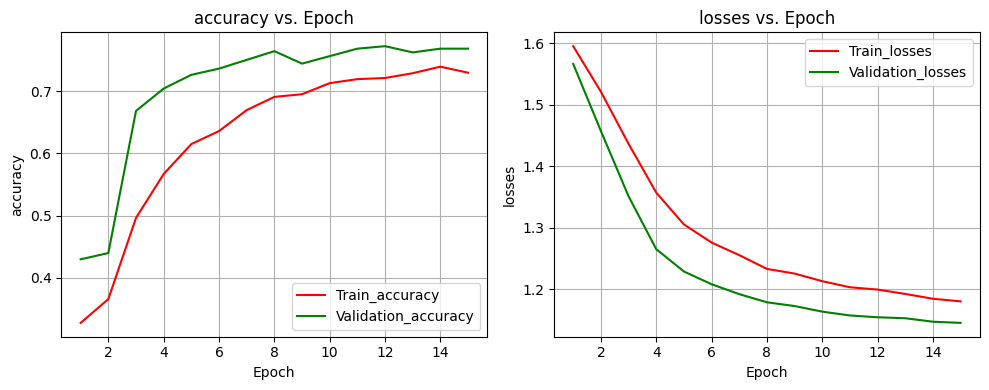

In [100]:
plot_findings(len(train_accuracies), [[train_accuracies, validation_accuracies], [train_losses, validation_losses]], "Epoch", isoptimal=True)

## Here lies the optimization for most of the hyperparameters and how we derived them


### (b) Different modes (aggregation methods used, and all their accuracies):
also assuming that the other parameters used are constant, for eg batch_size, hidden_dim, etc etc

#### Mean Mode


$ GPU Activated $
[1, 3, 0, 'OTHERS', 4]
{1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}
Length of num_labels:  5


 34%|███▍      | 17/50 [00:06<00:13,  2.43it/s]

Early stopping at epoch (18) due to no improvement in accuracy.
Time taken for the model to run finish: 7.00 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8360



 36%|███▌      | 18/50 [00:07<00:12,  2.55it/s]

Early stopping at epoch (19) due to no improvement in accuracy.
Time taken for the model to run finish: 7.07 seconds
Time taken to run finish the test: 0.02 seconds
Test Accuracy: 0.8380



 16%|█▌        | 8/50 [00:03<00:17,  2.44it/s]

Early stopping at epoch (9) due to no improvement in accuracy.
Time taken for the model to run finish: 3.28 seconds
Time taken to run finish the test: 0.02 seconds
Test Accuracy: 0.8040



 38%|███▊      | 19/50 [00:07<00:12,  2.56it/s]

Early stopping at epoch (20) due to no improvement in accuracy.
Time taken for the model to run finish: 7.41 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8220



 36%|███▌      | 18/50 [00:07<00:13,  2.38it/s]

Early stopping at epoch (19) due to no improvement in accuracy.
Time taken for the model to run finish: 7.56 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8420


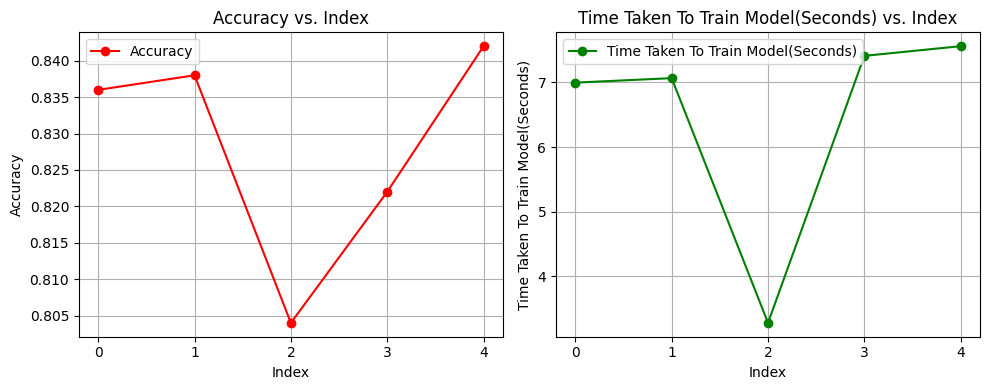

Best accuracy from Mean Runs: 4, 0.842
Average accuracy from Mean Runs: 0.8283999999999999


In [49]:
batch_size = 128
hidden_dim = 256
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
dropout_prob = 0.2
mode = "mean"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

acc, tt = [], []
predicted_labels, actual_labels = [], []
mean_run_index = [i for i in range(5)]

for run in mean_run_index:
    train_data_loader, validation_data_loader = get_training_data(
        batch_size, w2v, train_df, validation_df)
    test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)
    model = get_model(embedding_dim, hidden_dim, num_labels,
                      pretrained_embeddings, dropout_prob=dropout_prob)
    early_stopper = EarlyStopper(patience=3)

    _, _, _, _, time_taken = train_model(model, train_data_loader, validation_data_loader, mode=mode,
                                         device=device, epochs=epoch, random_initial_state=False,
                                         learning_rate=learning_rate, early_stopper=early_stopper, debug=False)
    predicted_label, actual_label, test_accuracy = test_model(
        model=model, test_data_loader=test_data_loader, mode=mode, device=device)
    acc.append(test_accuracy)
    tt.append(time_taken)
    predicted_labels.append(predicted_label)
    actual_labels.append(actual_label)

plot_findings(mean_run_index, [acc, tt], "Index")
print(f"Best accuracy from Mean Runs: {mean_run_index[acc.index(max(acc))]}, {max(acc)}")
print(f"Average accuracy from Mean Runs: {sum(acc)/len(acc)}")

In [50]:
print(predicted_labels[acc.index(max(acc))])
print(actual_labels[acc.index(max(acc))])
print("Predicted labels:",[labels_dict_inverse[i] for i in predicted_labels[acc.index(max(acc))]])
print("Actual labels:   ",[labels_dict_inverse[i] for i in actual_labels[acc.index(max(acc))]])

[1, 0, 3, 2, 2, 1, 2, 2, 3, 0, 2, 0, 4, 4, 3, 0, 2, 3, 3, 2, 4, 3, 3, 4, 1, 2, 2, 2, 3, 0, 0, 4, 2, 2, 3, 4, 3, 4, 4, 2, 2, 3, 4, 4, 2, 3, 3, 1, 2, 0, 0, 3, 0, 2, 3, 4, 3, 2, 4, 2, 2, 4, 4, 2, 2, 3, 2, 2, 3, 4, 4, 3, 2, 1, 2, 1, 3, 2, 2, 4, 4, 2, 1, 4, 4, 2, 2, 0, 4, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 4, 3, 4, 3, 2, 4, 1, 0, 4, 4, 0, 4, 4, 2, 2, 4, 2, 4, 2, 0, 3, 4, 4, 0, 0, 1, 3, 4, 3, 2, 2, 4, 1, 2, 2, 2, 4, 1, 3, 0, 2, 3, 0, 3, 2, 1, 3, 4, 3, 3, 1, 3, 2, 3, 4, 4, 4, 4, 3, 2, 2, 0, 4, 2, 0, 3, 3, 2, 2, 2, 4, 4, 3, 2, 2, 0, 4, 2, 0, 2, 4, 2, 2, 4, 2, 1, 3, 0, 4, 4, 0, 3, 3, 0, 2, 1, 2, 1, 1, 2, 3, 1, 4, 2, 3, 4, 4, 1, 0, 0, 4, 3, 0, 4, 3, 3, 4, 2, 2, 0, 1, 2, 4, 4, 2, 4, 3, 1, 0, 2, 3, 4, 3, 2, 4, 2, 1, 3, 1, 3, 1, 4, 0, 3, 4, 2, 1, 2, 2, 1, 3, 3, 3, 2, 0, 1, 4, 2, 3, 2, 3, 1, 2, 3, 1, 4, 2, 4, 2, 2, 3, 3, 2, 1, 1, 4, 0, 2, 4, 2, 0, 3, 3, 3, 4, 2, 4, 4, 3, 0, 3, 3, 4, 4, 0, 3, 0, 3, 0, 2, 3, 3, 2, 2, 3, 3, 2, 3, 2, 2, 1, 2, 2, 0, 0, 1, 2, 4, 2, 2, 2, 1, 4, 2, 0, 2, 0, 1, 1, 4, 0, 4, 2, 2, 

#### Max Mode


$ GPU Activated $
[1, 3, 0, 'OTHERS', 4]
{1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}
Length of num_labels:  5


 16%|█▌        | 8/50 [00:01<00:08,  4.99it/s]

Early stopping at epoch (9) due to no improvement in accuracy.
Time taken for the model to run finish: 1.60 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.7280



 18%|█▊        | 9/50 [00:01<00:07,  5.39it/s]

Early stopping at epoch (10) due to no improvement in accuracy.
Time taken for the model to run finish: 1.67 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.7620



 16%|█▌        | 8/50 [00:01<00:08,  5.07it/s]


Early stopping at epoch (9) due to no improvement in accuracy.
Time taken for the model to run finish: 1.58 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.7240


 22%|██▏       | 11/50 [00:02<00:07,  5.46it/s]


Early stopping at epoch (12) due to no improvement in accuracy.
Time taken for the model to run finish: 2.02 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.7200


 18%|█▊        | 9/50 [00:01<00:08,  5.05it/s]


Early stopping at epoch (10) due to no improvement in accuracy.
Time taken for the model to run finish: 1.78 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.7400


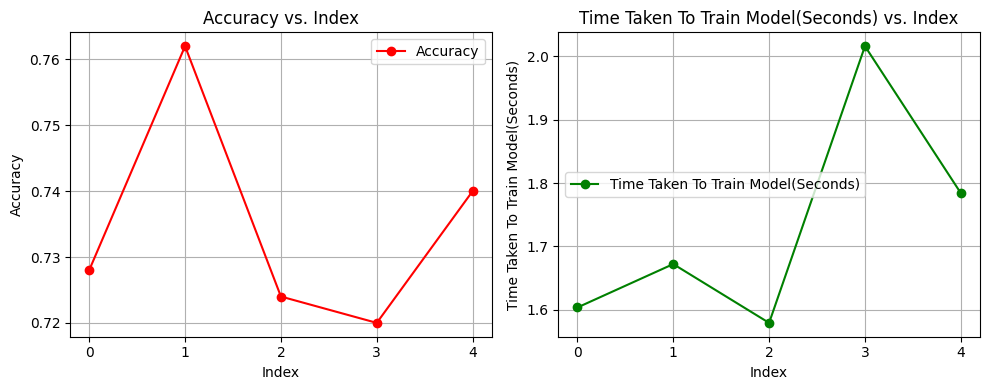

Best accuracy from Max Runs: 1, 0.762
Average accuracy from Max Runs: 0.7348000000000001


In [51]:
batch_size = 128
hidden_dim = 256
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
dropout_prob = 0.2
mode = "max"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

acc, tt = [], []
predicted_labels, actual_labels = [], []
max_run_index = [i for i in range(5)]

for run in max_run_index:
    train_data_loader, validation_data_loader = get_training_data(
        batch_size, w2v, train_df, validation_df)
    test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)
    model = get_model(embedding_dim, hidden_dim, num_labels,
                      pretrained_embeddings, dropout_prob=dropout_prob)
    early_stopper = EarlyStopper(patience=3)

    _, _, _, _, time_taken = train_model(model, train_data_loader, validation_data_loader, mode=mode,
                                         device=device, epochs=epoch, random_initial_state=False,
                                         learning_rate=learning_rate, early_stopper=early_stopper, debug=False)
    predicted_label, actual_label, test_accuracy = test_model(
        model=model, test_data_loader=test_data_loader, mode=mode, device=device)
    acc.append(test_accuracy)
    tt.append(time_taken)
    predicted_labels.append(predicted_label)
    actual_labels.append(actual_label)

plot_findings(max_run_index, [acc, tt], "Index")
print(f"Best accuracy from Max Runs: {max_run_index[acc.index(max(acc))]}, {max(acc)}")
print(f"Average accuracy from Max Runs: {sum(acc)/len(acc)}")

In [52]:
print(predicted_labels[acc.index(max(acc))])
print(actual_labels[acc.index(max(acc))])
print("Predicted labels:",[labels_dict_inverse[i] for i in predicted_labels[acc.index(max(acc))]])
print("Actual labels:   ",[labels_dict_inverse[i] for i in actual_labels[acc.index(max(acc))]])

[1, 0, 3, 2, 2, 1, 2, 2, 3, 0, 2, 0, 4, 4, 3, 0, 0, 3, 3, 2, 4, 4, 0, 4, 1, 0, 0, 2, 3, 0, 2, 3, 2, 2, 3, 4, 3, 4, 4, 2, 2, 4, 4, 4, 2, 3, 3, 1, 0, 0, 0, 3, 2, 4, 3, 4, 0, 0, 4, 2, 2, 0, 0, 2, 2, 3, 0, 2, 2, 4, 4, 3, 0, 1, 2, 1, 3, 0, 0, 4, 0, 0, 0, 4, 4, 2, 2, 4, 4, 0, 2, 3, 2, 0, 0, 2, 1, 2, 2, 0, 3, 4, 3, 2, 4, 1, 0, 4, 3, 0, 4, 4, 2, 2, 4, 2, 4, 0, 3, 3, 4, 4, 0, 1, 1, 0, 1, 3, 2, 2, 4, 0, 4, 0, 2, 4, 1, 3, 2, 0, 3, 0, 3, 2, 1, 0, 4, 3, 3, 1, 3, 0, 4, 4, 4, 4, 4, 3, 2, 0, 0, 4, 4, 0, 3, 3, 2, 2, 2, 4, 4, 3, 2, 2, 0, 4, 2, 1, 2, 1, 2, 2, 4, 0, 1, 3, 0, 4, 4, 0, 3, 3, 0, 2, 2, 2, 1, 1, 4, 3, 1, 4, 2, 3, 4, 4, 1, 0, 0, 4, 0, 2, 4, 3, 3, 4, 2, 3, 0, 1, 2, 4, 4, 2, 4, 3, 1, 0, 2, 3, 4, 4, 2, 4, 2, 1, 3, 1, 3, 1, 4, 0, 3, 4, 0, 1, 2, 2, 1, 3, 3, 3, 2, 1, 1, 4, 2, 3, 2, 3, 1, 2, 3, 1, 4, 1, 4, 2, 2, 3, 3, 4, 1, 3, 4, 0, 2, 4, 4, 4, 3, 3, 3, 0, 2, 4, 4, 3, 0, 0, 3, 0, 4, 0, 3, 0, 3, 0, 2, 0, 3, 4, 0, 3, 1, 0, 3, 0, 2, 1, 2, 2, 0, 0, 1, 2, 4, 2, 2, 2, 1, 4, 2, 0, 0, 0, 1, 1, 4, 1, 4, 0, 2, 

#### RNN Mode


$ GPU Activated $
[1, 3, 0, 'OTHERS', 4]
{1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}
Length of num_labels:  5


 18%|█▊        | 9/50 [00:03<00:15,  2.58it/s]

Early stopping at epoch (10) due to no improvement in accuracy.
Time taken for the model to run finish: 3.49 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.1300



 10%|█         | 5/50 [00:02<00:18,  2.50it/s]

Early stopping at epoch (6) due to no improvement in accuracy.
Time taken for the model to run finish: 2.00 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.1880



 12%|█▏        | 6/50 [00:02<00:17,  2.54it/s]

Early stopping at epoch (7) due to no improvement in accuracy.
Time taken for the model to run finish: 2.37 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.1880



  6%|▌         | 3/50 [00:01<00:20,  2.34it/s]

Early stopping at epoch (4) due to no improvement in accuracy.
Time taken for the model to run finish: 1.28 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.1880



  6%|▌         | 3/50 [00:01<00:20,  2.30it/s]

Early stopping at epoch (4) due to no improvement in accuracy.
Time taken for the model to run finish: 1.31 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.1880


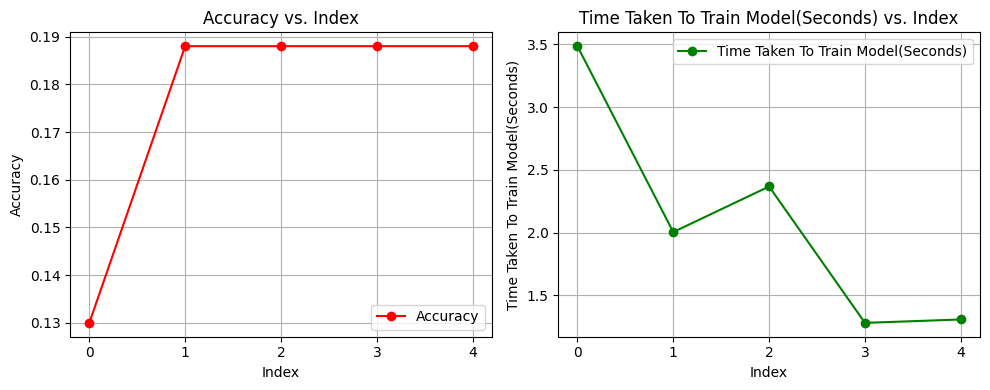

Best accuracy from RNN Runs: 1, 0.188
Average accuracy from RNN Runs: 0.17639999999999997


In [53]:
batch_size = 128
hidden_dim = 256
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
dropout_prob = 0.2
mode = "rnn"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

acc, tt = [], []
predicted_labels, actual_labels = [], []
rnn_run_index = [i for i in range(5)]

for run in rnn_run_index:
    train_data_loader, validation_data_loader = get_training_data(
        batch_size, w2v, train_df, validation_df)
    test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)
    model = get_model(embedding_dim, hidden_dim, num_labels,
                      pretrained_embeddings, dropout_prob=dropout_prob)
    early_stopper = EarlyStopper(patience=3)

    _, _, _, _, time_taken = train_model(model, train_data_loader, validation_data_loader, mode=mode,
                                         device=device, epochs=epoch, random_initial_state=False,
                                         learning_rate=learning_rate, early_stopper=early_stopper, debug=False)
    predicted_label, actual_label, test_accuracy = test_model(model=model, test_data_loader=test_data_loader, mode=mode, device=device)
    acc.append(test_accuracy)
    tt.append(time_taken)
    predicted_labels.append(predicted_label)
    actual_labels.append(actual_label)

plot_findings(rnn_run_index, [acc, tt], "Index")
print(f"Best accuracy from RNN Runs: {rnn_run_index[acc.index(max(acc))]}, {max(acc)}")
print(f"Average accuracy from RNN Runs: {sum(acc)/len(acc)}")

In [54]:
print(predicted_labels[acc.index(max(acc))])
print(actual_labels[acc.index(max(acc))])
print("Predicted labels:",[labels_dict_inverse[i] for i in predicted_labels[acc.index(max(acc))]])
print("Actual labels:   ",[labels_dict_inverse[i] for i in actual_labels[acc.index(max(acc))]])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

#### RNN Multi

$ GPU Activated $
[1, 3, 0, 'OTHERS', 4]
{1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}
Length of num_labels:  5


 22%|██▏       | 11/50 [00:07<00:26,  1.46it/s]

Early stopping at epoch (12) due to no improvement in accuracy.
Time taken for the model to run finish: 7.53 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.2860



 22%|██▏       | 11/50 [00:07<00:27,  1.43it/s]

Early stopping at epoch (12) due to no improvement in accuracy.
Time taken for the model to run finish: 7.68 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.3980



 20%|██        | 10/50 [00:07<00:28,  1.42it/s]

Early stopping at epoch (11) due to no improvement in accuracy.
Time taken for the model to run finish: 7.03 seconds
Time taken to run finish the test: 0.02 seconds
Test Accuracy: 0.4480



 18%|█▊        | 9/50 [00:06<00:29,  1.39it/s]

Early stopping at epoch (10) due to no improvement in accuracy.
Time taken for the model to run finish: 6.48 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.3060



 18%|█▊        | 9/50 [00:06<00:30,  1.36it/s]

Early stopping at epoch (10) due to no improvement in accuracy.
Time taken for the model to run finish: 6.63 seconds
Time taken to run finish the test: 0.02 seconds
Test Accuracy: 0.3700


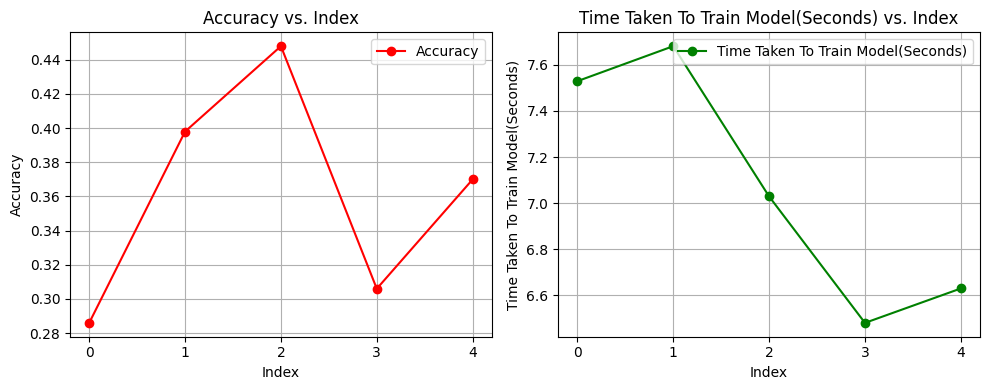

Best accuracy from RNN Multi Runs: 2, 0.448
Average accuracy from RNN Multi Runs: 0.3616


In [55]:
batch_size = 128
hidden_dim = 256
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
dropout_prob = 0.2
mode = "rnnmulti"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

acc, tt = [], []
predicted_labels, actual_labels = [], []
rnn_multi_run_index = [i for i in range(5)]

for run in rnn_multi_run_index:
    train_data_loader, validation_data_loader = get_training_data(
        batch_size, w2v, train_df, validation_df)
    test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)
    model = get_model(embedding_dim, hidden_dim, num_labels,
                      pretrained_embeddings, dropout_prob=dropout_prob)
    early_stopper = EarlyStopper(patience=3)

    _, _, _, _, time_taken = train_model(model, train_data_loader, validation_data_loader, mode=mode,
                                         device=device, epochs=epoch, random_initial_state=False,
                                         learning_rate=learning_rate, early_stopper=early_stopper, debug=False)
    predicted_label, actual_label, test_accuracy = test_model(model=model, test_data_loader=test_data_loader, mode=mode, device=device)
    acc.append(test_accuracy)
    tt.append(time_taken)
    predicted_labels.append(predicted_label)
    actual_labels.append(actual_label)

plot_findings(rnn_multi_run_index, [acc, tt], "Index")
print(f"Best accuracy from RNN Multi Runs: {rnn_multi_run_index[acc.index(max(acc))]}, {max(acc)}")
print(f"Average accuracy from RNN Multi Runs: {sum(acc)/len(acc)}")

In [56]:
print(predicted_labels[acc.index(max(acc))])
print(actual_labels[acc.index(max(acc))])
print("Predicted labels:",[labels_dict_inverse[i] for i in predicted_labels[acc.index(max(acc))]])
print("Actual labels:   ",[labels_dict_inverse[i] for i in actual_labels[acc.index(max(acc))]])

[1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 4, 0, 0, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 3, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 4, 1, 0, 0, 0, 0, 4, 4, 0, 0, 4, 0, 4, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 1, 3, 0, 0, 4, 0, 4, 4, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 4, 4, 0, 0, 4, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 4, 4, 0, 4, 0, 3, 4, 0, 0, 0, 0, 0, 0, 4, 0, 4, 1, 1, 0, 0, 0, 0, 3, 0, 4, 0, 1, 0, 1, 3, 0, 0, 0, 0, 4, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 0, 4, 0, 0, 1, 3, 3, 0, 0, 4, 4, 3, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 4, 0, 0, 0, 1, 4, 0, 0, 0, 0, 1, 1, 0, 0, 4, 0, 0, 

### Best score for Batch Size:


$ GPU Activated $
[1, 3, 0, 'OTHERS', 4]
{1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}
Length of num_labels:  5


 24%|██▍       | 12/50 [00:11<00:35,  1.06it/s]

Early stopping at epoch (13) due to no improvement in accuracy.
Time taken for the model to run finish: 11.27 seconds
Time taken to run finish the test: 0.04 seconds
Test Accuracy: 0.8280



 24%|██▍       | 12/50 [00:07<00:22,  1.69it/s]

Early stopping at epoch (13) due to no improvement in accuracy.
Time taken for the model to run finish: 7.12 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8320



 34%|███▍      | 17/50 [00:08<00:15,  2.12it/s]

Early stopping at epoch (18) due to no improvement in accuracy.
Time taken for the model to run finish: 8.02 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8460



 24%|██▍       | 12/50 [00:04<00:15,  2.43it/s]

Early stopping at epoch (13) due to no improvement in accuracy.
Time taken for the model to run finish: 4.95 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8020



 76%|███████▌  | 38/50 [00:12<00:03,  3.01it/s]

Early stopping at epoch (39) due to no improvement in accuracy.
Time taken for the model to run finish: 12.62 seconds
Time taken to run finish the test: 0.02 seconds
Test Accuracy: 0.8460



 16%|█▌        | 8/50 [00:02<00:14,  2.87it/s]

Early stopping at epoch (9) due to no improvement in accuracy.
Time taken for the model to run finish: 2.79 seconds
Time taken to run finish the test: 0.02 seconds
Test Accuracy: 0.4020


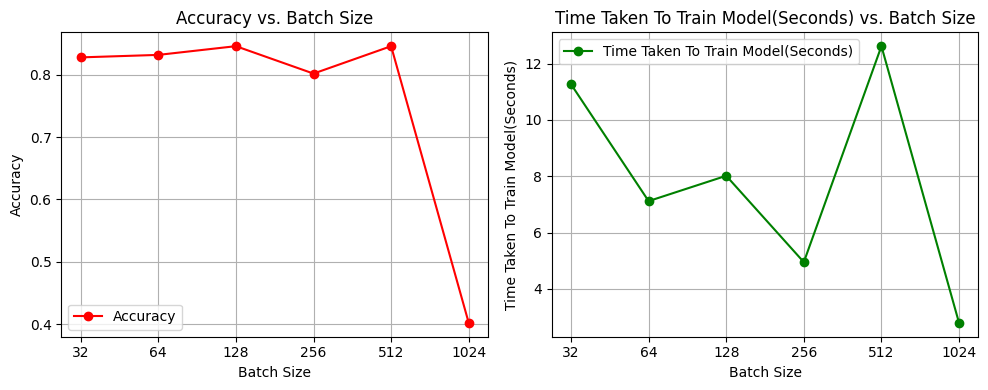

Best accuracy for Batch Size: 128, 0.846


In [46]:
# batch_size = 32
hidden_dim = 256
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
dropout_prob = 0.2
mode = "mean"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

acc, tt = [], []
batch_size = [32, 64, 128, 256, 512, 1024]
for BS in batch_size:
    train_data_loader, validation_data_loader = get_training_data(
        BS, w2v, train_df, validation_df)
    test_data_loader = get_test_data(BS, w2v, random_seed=random_seed)
    model = get_model(embedding_dim, hidden_dim, num_labels,
                      pretrained_embeddings, dropout_prob=dropout_prob)
    early_stopper = EarlyStopper(patience=3)

    _, _, _, _, time_taken = train_model(model, train_data_loader, validation_data_loader, mode=mode,
                                         device=device, epochs=epoch, random_initial_state=False,
                                         learning_rate=learning_rate, early_stopper=early_stopper, debug=False)
    _, _, test_accuracy = test_model(
        model=model, test_data_loader=test_data_loader, mode=mode, device=device)
    acc.append(test_accuracy)
    tt.append(time_taken)

plot_findings(batch_size, [acc, tt], "Batch Size")
print(f"Best accuracy for Batch Size: {batch_size[acc.index(max(acc))]}, {max(acc)}")

### Best score for Hidden Dimension:


$ GPU Activated $
[1, 3, 0, 'OTHERS', 4]
{1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}
Length of num_labels:  5


 46%|████▌     | 23/50 [00:09<00:10,  2.55it/s]

Early stopping at epoch (24) due to no improvement in accuracy.
Time taken for the model to run finish: 9.02 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8240



 24%|██▍       | 12/50 [00:04<00:15,  2.49it/s]


Early stopping at epoch (13) due to no improvement in accuracy.
Time taken for the model to run finish: 4.82 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8140


 38%|███▊      | 19/50 [00:07<00:12,  2.52it/s]

Early stopping at epoch (20) due to no improvement in accuracy.
Time taken for the model to run finish: 7.55 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8260



 34%|███▍      | 17/50 [00:07<00:13,  2.37it/s]

Early stopping at epoch (18) due to no improvement in accuracy.
Time taken for the model to run finish: 7.19 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8400



 16%|█▌        | 8/50 [00:03<00:19,  2.17it/s]

Early stopping at epoch (9) due to no improvement in accuracy.
Time taken for the model to run finish: 3.69 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8300



 14%|█▍        | 7/50 [00:03<00:23,  1.81it/s]

Early stopping at epoch (8) due to no improvement in accuracy.
Time taken for the model to run finish: 3.87 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8300


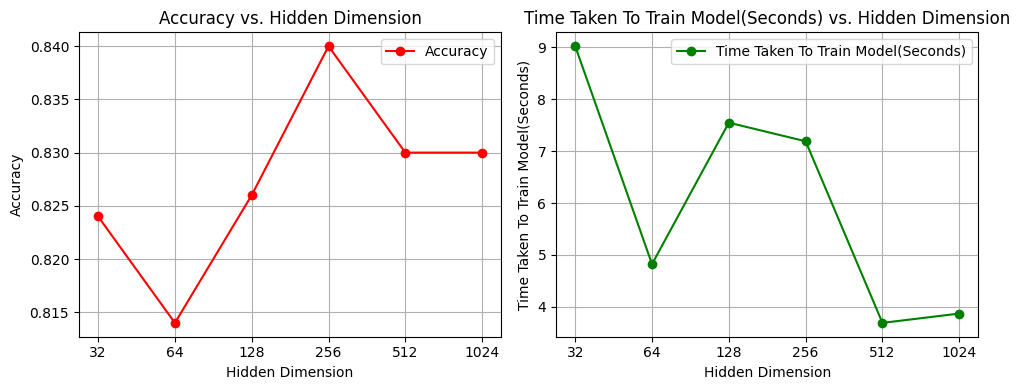

Best accuracy for Hidden Dimension: 256, 0.84


In [45]:
batch_size = 128
# hidden_dim = 512
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
dropout_prob = 0.2
mode = "mean"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

acc, tt = [], []
hidden_dim = [32, 64, 128, 256, 512, 1024]
for HD in hidden_dim:
    train_data_loader, validation_data_loader = get_training_data(
        batch_size, w2v, train_df, validation_df)
    test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)
    model = get_model(embedding_dim, HD, num_labels,
                      pretrained_embeddings, dropout_prob=dropout_prob)
    early_stopper = EarlyStopper(patience=3)

    _, _, _, _, time_taken = train_model(model, train_data_loader, validation_data_loader, mode=mode,
                                         device=device, epochs=epoch, random_initial_state=False,
                                         learning_rate=learning_rate, early_stopper=early_stopper, debug=False)
    _, _, test_accuracy = test_model(
        model=model, test_data_loader=test_data_loader, mode=mode, device=device)
    acc.append(test_accuracy)
    tt.append(time_taken)

plot_findings(hidden_dim, [acc, tt], "Hidden Dimension")
print(f"Best accuracy for Hidden Dimension: {hidden_dim[acc.index(max(acc))]}, {max(acc)}")

### Best score for Learning Rate:


$ GPU Activated $
[1, 3, 0, 'OTHERS', 4]
{1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}
Length of num_labels:  5


 76%|███████▌  | 38/50 [00:15<00:04,  2.49it/s]

Early stopping at epoch (39) due to no improvement in accuracy.
Time taken for the model to run finish: 15.26 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.7340



 42%|████▏     | 21/50 [00:08<00:12,  2.39it/s]

Early stopping at epoch (22) due to no improvement in accuracy.
Time taken for the model to run finish: 8.77 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8360



 16%|█▌        | 8/50 [00:03<00:19,  2.17it/s]

Early stopping at epoch (9) due to no improvement in accuracy.
Time taken for the model to run finish: 3.68 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8180



 24%|██▍       | 12/50 [00:05<00:16,  2.35it/s]

Early stopping at epoch (13) due to no improvement in accuracy.
Time taken for the model to run finish: 5.11 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8080



100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


Time taken for the model to run finish: 19.44 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.2760


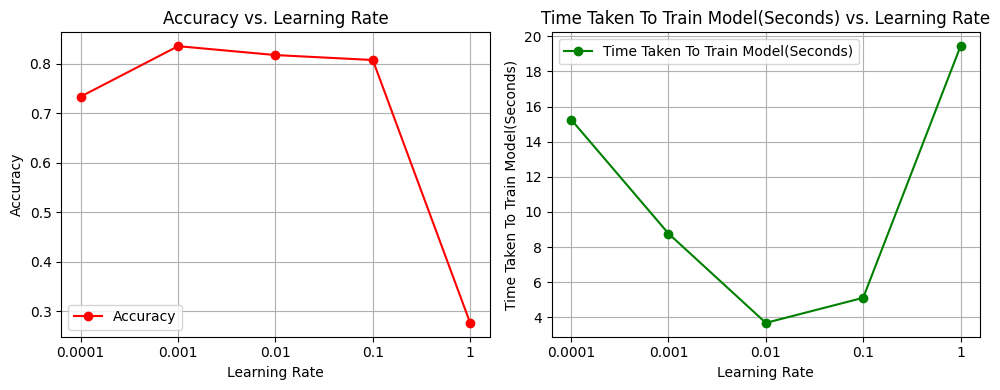

Best accuracy for Learning Rate: 0.001, 0.836


In [74]:
batch_size = 128
hidden_dim = 256
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
# learning_rate = 0.001
dropout_prob = 0.2
mode = "mean"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

acc, tt = [], []
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1]
for lr in learning_rate:
    train_data_loader, validation_data_loader = get_training_data(
        batch_size, w2v, train_df, validation_df)
    test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)
    model = get_model(embedding_dim, hidden_dim, num_labels,
                      pretrained_embeddings, dropout_prob=dropout_prob)
    early_stopper = EarlyStopper(patience=3)

    _, _, _, _, time_taken = train_model(model, train_data_loader, validation_data_loader, mode=mode,
                                         device=device, epochs=epoch, random_initial_state=False,
                                         learning_rate=lr, early_stopper=early_stopper, debug=False)
    _, _, test_accuracy = test_model(
        model=model, test_data_loader=test_data_loader, mode=mode, device=device)
    acc.append(test_accuracy)
    tt.append(time_taken)

plot_findings(learning_rate, [acc, tt], "Learning Rate")
print(f"Best accuracy for Learning Rate: {learning_rate[acc.index(max(acc))]}, {max(acc)}")

### Best score for Dropout Probability:


$ GPU Activated $
[1, 3, 0, 'OTHERS', 4]
{1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}
Length of num_labels:  5


 38%|███▊      | 19/50 [00:07<00:12,  2.41it/s]

Early stopping at epoch (20) due to no improvement in accuracy.
Time taken for the model to run finish: 7.88 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8320



 28%|██▊       | 14/50 [00:05<00:14,  2.52it/s]

Early stopping at epoch (15) due to no improvement in accuracy.
Time taken for the model to run finish: 5.55 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8420



 26%|██▌       | 13/50 [00:05<00:14,  2.50it/s]

Early stopping at epoch (14) due to no improvement in accuracy.
Time taken for the model to run finish: 5.19 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8220



 36%|███▌      | 18/50 [00:07<00:12,  2.55it/s]

Early stopping at epoch (19) due to no improvement in accuracy.
Time taken for the model to run finish: 7.06 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8320



 26%|██▌       | 13/50 [00:05<00:14,  2.49it/s]

Early stopping at epoch (14) due to no improvement in accuracy.
Time taken for the model to run finish: 5.22 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8480


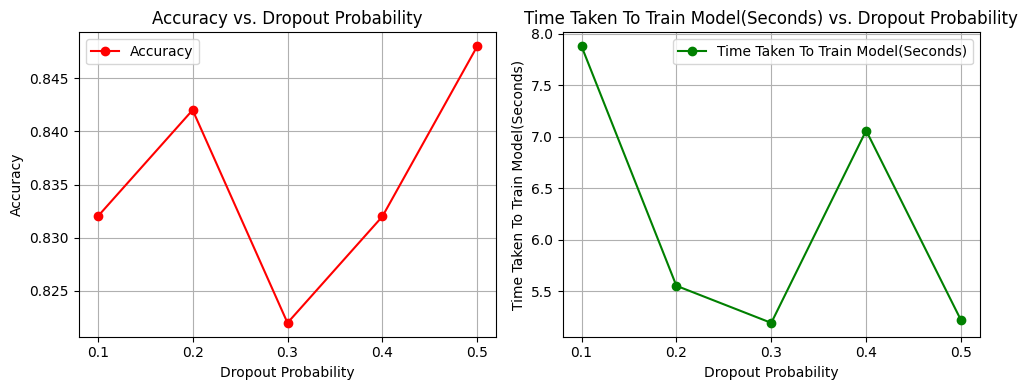

Best accuracy for Dropout Probability: 0.5, 0.848


In [48]:
batch_size = 128
hidden_dim = 256
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
# dropout_prob = 0.2
mode = "mean"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

acc, tt = [], []
dropout_prob = [0.1, 0.2, 0.3, 0.4, 0.5]
for dp in dropout_prob:
    train_data_loader, validation_data_loader = get_training_data(
        batch_size, w2v, train_df, validation_df)
    test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)
    model = get_model(embedding_dim, hidden_dim, num_labels,
                      pretrained_embeddings, dropout_prob=dp)
    early_stopper = EarlyStopper(patience=3)

    _, _, _, _, time_taken = train_model(model, train_data_loader, validation_data_loader, mode=mode,
                                         device=device, epochs=epoch, random_initial_state=False,
                                         learning_rate=learning_rate, early_stopper=early_stopper, debug=False)
    _, _, test_accuracy = test_model(
        model=model, test_data_loader=test_data_loader, mode=mode, device=device)
    acc.append(test_accuracy)
    tt.append(time_taken)

plot_findings(dropout_prob, [acc, tt], "Dropout Probability")
print(f"Best accuracy for Dropout Probability: {dropout_prob[acc.index(max(acc))]}, {max(acc)}")

## Defining a function to process a single sentence from the test df


In [57]:
def preprocess_sentence(sentence, w2v_model, max_sentence_len):
    # Tokenize the sentence and convert the tokens to their corresponding indices in the word2vec model
    word_to_index = [w2v_model.key_to_index[word] if word in w2v_model.key_to_index else 3000000 for word in sentence.split()]

    # Save the actual length of the sentence
    actual_len = len(word_to_index)

    # Pad the tokenized sentence to max_sentence_len
    if len(word_to_index) < max_sentence_len:
        num_padding = max_sentence_len - len(word_to_index)
        word_to_index += [3000000] * num_padding

    # Convert the tokenized sentence to a tensor and add an extra dimension to make it a batch
    sentence_tensor = torch.tensor(word_to_index).unsqueeze(0).to(device)

    return sentence_tensor, torch.tensor([actual_len])

### Optimal Parameter Model

In [58]:
# # TO FIND OPTIMAL PARAMETERS
batch_size = 128
hidden_dim = 256
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
dropout_prob = 0.2
mode = "mean"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

train_data_loader, validation_data_loader = get_training_data(batch_size, w2v, train_df, validation_df)
test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)

model = get_model(embedding_dim, hidden_dim, num_labels,
                  pretrained_embeddings, dropout_prob=dropout_prob)

# Train the model
train_accuracies, validation_accuracies, train_losses, validation_losses, time_taken = train_model(
    model=model, train_data_loader=train_data_loader, validation_data_loader=validation_data_loader,
    mode=mode, device=device, epochs=epoch, random_initial_state=False, learning_rate=learning_rate,
    early_stopper=early_stopper, debug=False)

# Obtain the accuracy of the model using test set
_, _, test_accuracy = test_model(
    model=model, test_data_loader=test_data_loader, mode=mode, device=device)

$ GPU Activated $
[1, 3, 0, 'OTHERS', 4]
{1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}
Length of num_labels:  5


 30%|███       | 15/50 [00:06<00:16,  2.18it/s]

Early stopping at epoch (16) due to no improvement in accuracy.
Time taken for the model to run finish: 6.88 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8420


### Testing for a sentence in test.csv


In [59]:
sentence_index = 3
# Test model on one sentence
sentence = test_df.loc[sentence_index, 'text']
max_sentence_len = max(test_df['text'].apply(lambda x: len(x.split())))
preprocessed_input, sentence_len = preprocess_sentence(sentence, w2v, max_sentence_len)
output = model(preprocessed_input, sentence_len=sentence_len,mode=mode, _device=device)

# Get the predicted label
predicted_label = torch.argmax(output, dim=1)

# Convert the predicted label to its original string form
predicted_label_str = labels_dict_inverse[predicted_label.item()]

print(predicted_label_str)

0


In [60]:
print(test_df.loc[sentence_index])

label-coarse                    0
label-fine                      7
text            What is an atom ?
Name: 3, dtype: object
